In [ ]:
! pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 4.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=985f2fdd1fbf1b86c9f78117d489fea4b55ba9770837498483215184191c4e27
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # Example model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression, LassoCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from lifelines.utils import concordance_index
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading & Preprocessing

## 1. Load <u>clinical data</u> and perform feature selection (Lasso)

In [ ]:
#---CLINICAL DATA---

# Removing mixed tumor type from consideration
clinical_df = pd.read_csv('/content/drive/MyDrive/Masters/AIO/InitialClinicalData.csv')
clinical_df = clinical_df.rename(columns={" ID":"ID"})
clinical_df.set_index("ID", inplace=True)
print("Before removing mix type samples:", clinical_df.shape)
rows_before = clinical_df.shape[0]
clinical_df = clinical_df[~clinical_df.index.str.contains("MIX")]
rows_after = clinical_df.shape[0]
print("Number rows removed (mixed tumor type):", rows_before-rows_after)
print()
#download PFS and filter out patients without measured data (apply filter on clinical_data_df too)
pfs_df = pd.read_csv('/content/drive/MyDrive/Masters/AIO/pfs.csv')
pfs_df = pfs_df.rename(columns={" ID":"ID"})
pfs_df.set_index("ID", inplace=True)
print("original PFS data shape:", pfs_df.shape)
pfs_df = pfs_df[pfs_df["Progression-free time (months)"]!="[Not Available]"]
pfs_df = pfs_df.astype(int)
print("PFS after removing rows without PFS Data:", pfs_df.shape)

clinical_df = clinical_df[clinical_df.index.isin(pfs_df.index)]
clinical_df.shape
print()

#Separately process Complete Blood Count (CBC) data and perform PCA
#Starting with removing samples with no CBC data collected
cbc_df = clinical_df.iloc[:,21:]# 67 features
clinical_df = clinical_df.iloc[:,:21]
print("Before dropping Group ID col and 4 cols with sparse data:",clinical_df.shape)
clinical_df = clinical_df.drop(clinical_df.iloc[:, 2:6], axis=1) #drop some columns with sparse data
clinical_df.drop(["Group-TMT ID"], axis=1, inplace=True)
print("After dropping 4 cols with sparse data, Group-TMT ID col",clinical_df.shape)
print("CBC data before dropping NAs:", cbc_df.shape)
cbc_df = cbc_df.dropna(how='all')
cbc_df.replace(0, np.nan, inplace=True)
print("CBC data after dropping NAs:", cbc_df.shape)

print()

print("Filter clinical and CBC data by available PFS")
clinical_df = clinical_df[clinical_df.index.isin(pfs_df.index)]
print("clinical data:",clinical_df.shape)
cbc_df = cbc_df[cbc_df.index.isin(pfs_df.index)]
print("cbc data:", cbc_df.shape)

print()

print("Merge onto smallest data set (CBC data)")
pfs_df = pfs_df[pfs_df.index.isin(cbc_df.index)]
print("pfs data:", pfs_df.shape)
clinical_df = clinical_df[clinical_df.index.isin(cbc_df.index)]
print("clinical data:", clinical_df.shape)

y = pfs_df["Progression-free time (months)"]
train_idx, test_idx = train_test_split(y.index, test_size=0.2, random_state=42)
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

threshold = 0.75

Before removing mix type samples: (184, 88)
Number rows removed (mixed tumor type): 12

original PFS data shape: (139, 2)
PFS after removing rows without PFS Data: (137, 2)

Before dropping Group ID col and 4 cols with sparse data: (137, 21)
After dropping 4 cols with sparse data, Group-TMT ID col (137, 16)
CBC data before dropping NAs: (137, 67)
CBC data after dropping NAs: (133, 67)

Filter clinical and CBC data by available PFS
clinical data: (137, 16)
cbc data: (133, 67)

Merge onto smallest data set (CBC data)
pfs data: (133, 2)
clinical data: (133, 16)


In [ ]:
#Impute some empty categorical values for training later
#clinical_df.loc[clinical_df['Vaginal Secretion'].isna(),"Vaginal Secretion"] = "Unknown" #1 value updated

In [ ]:
X = cbc_df.copy()
X = X[X.index.isin(pfs_df.index)]
train_idx = train_idx[train_idx.isin(X.index)]
test_idx = test_idx[test_idx.isin(X.index)]
print("CBC dataset")
print("Original number of features:", str(X.shape[1]))
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)
scaler.fit(X_train_imputed) #only fitted once?

print("X_train after imputing:", X_train_imputed.shape)

# estimator = DecisionTreeClassifier()

sel_ = SelectFromModel(Lasso(alpha=1, random_state=10))
sel_.fit(scaler.transform(X_train_imputed), y_train)

# 3. LassoCV
# lasso = LassoCV(cv=5, random_state=43, max_iter=5000, verbose=True)
# lasso.fit(scaler.transform(X_train_imputed), y_train)

cbc_train_selected = sel_.transform(scaler.transform(X_train_imputed))

# Get the boolean mask of selected features
mask = sel_.get_support()

# Use it to filter the original column names
selected_features = X_train.columns[mask]
print("Num selected features:", str(len(selected_features)))
print("Selected features:", selected_features.tolist())

CBC dataset
Original number of features: 67
X_train after imputing: (106, 67)
Num selected features: 11
Selected features: ['aDC_xcell', 'CD4positive_Tcm_xcell', 'CD8positive_T_cells_xcell', 'CMP_xcell', 'Macrophages_M1_xcell', 'Megakaryocytes_xcell', 'Myocytes_xcell', 'Osteoblast_xcell', 'Skeletal_muscle_xcell', 'Th1_cells_xcell', 'Th2_cells_xcell']


In [ ]:
cbc_selected = cbc_df.copy()[selected_features]
cbc_selected = cbc_selected.add_prefix("CBC_")

cbc_selected_train = cbc_selected.loc[train_idx]
cbc_selected_test = cbc_selected.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

cbc_train = imputer.fit_transform(cbc_selected_train)
cbc_test = imputer.transform(cbc_selected_test)

cbc_train = scaler.fit_transform(cbc_train)
cbc_test = scaler.transform(cbc_test)

cbc_selected_train = pd.DataFrame(cbc_train, columns=selected_features, index=train_idx)
cbc_selected_test = pd.DataFrame(cbc_test, columns=selected_features, index=test_idx)

## 2. Proprocess <u>RNA seq</u> data (using LassoCV rather than Lasso)

In [ ]:
rna_seq_df = pd.read_csv('/content/drive/MyDrive/Masters/AIO/rna_seq.csv', index_col=0, header=0).T #take transpose of data, put samples in rows and RNA seq in columns
print("Original RNA seq", rna_seq_df.shape)
rna_seq_df = rna_seq_df[rna_seq_df.index.isin(pfs_df.index)]
print("pfs df shape:", pfs_df.shape)
print("rna seq shape", rna_seq_df.shape)
rna_seq_df.head()


Original RNA seq (161, 24595)
pfs df shape: (133, 2)
rna seq shape (133, 24595)


gene name,AL627309.1,AL627309.5,LINC01409,FAM87B,LINC01128,LINC00115,AL645608.6,AL645608.2,LINC02593,SAMD11,...,AL592183.1,AC240274.1,AC213203.2,AC004556.3,AC233755.2,AC233755.1,AC136616.1,AC141272.1,AC007325.4,AC007325.2
TB100-1,0.096448,0.792359,3.872883,1.384309,3.668036,15.053190,0.341279,0.000000,0.173105,0.875523,...,117.856754,34.558548,1.081127,42.816414,2.444670,1.365115,0.098188,0.000000,3.209511,31.379195
TB101-1,0.359360,2.012917,8.659514,2.469514,6.874064,12.431307,9.016677,26.621123,62.035258,81.047998,...,61.189787,43.842594,1.391563,80.601780,0.000000,0.000000,30.348139,0.000000,12.292934,26.951616
TB102-1,0.244301,1.642892,1.777530,1.669721,3.121759,8.047144,1.296674,1.111070,3.570405,7.556719,...,45.618133,11.162545,0.000000,0.351454,8.846115,52.978402,0.497413,0.000000,3.805726,16.275013
TB104-1,0.438349,1.005853,3.440943,1.388483,4.594914,10.947614,0.481370,0.684802,5.208818,12.065753,...,84.177719,27.026289,0.338871,0.456651,4.980711,15.082941,0.030776,1.173341,6.175273,191.887277
TB105-1,0.439860,0.627220,2.344650,1.954099,5.296762,8.177699,4.669281,2.808342,1.437944,2.286327,...,32.098617,9.582799,0.281746,0.553688,27.474567,35.353128,0.511762,1.219433,4.101637,17.912732


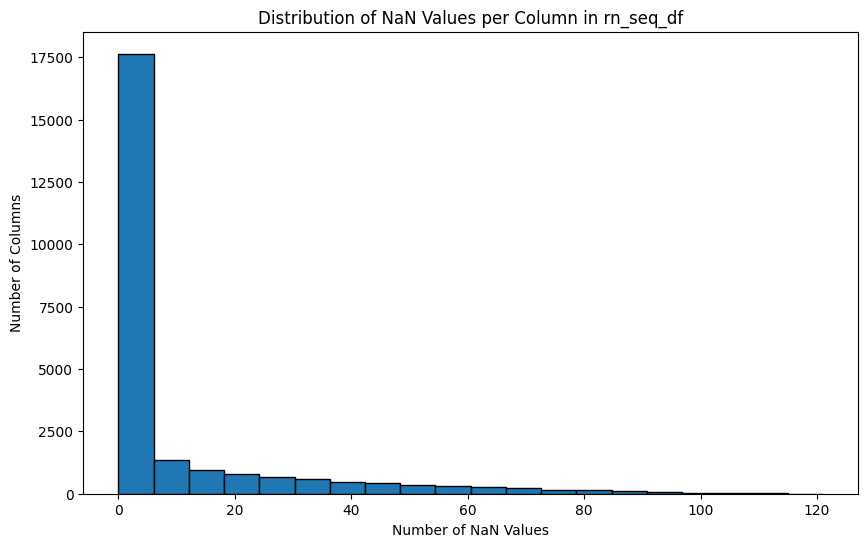

In [ ]:
# Count NaN values in each column
rna_seq_df.replace(0, np.nan, inplace=True)
nan_counts = rna_seq_df.isna().sum()
num_features = rna_seq_df.shape[1]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(nan_counts, bins=20, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in rn_seq_df')
plt.show()

rna seq df new shape (133, 21683)
features removed: 2912


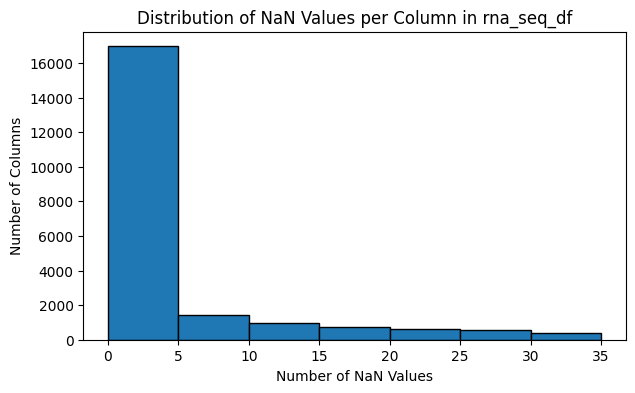

In [ ]:
#threshold = 0.75  # 75% OF DATA MUST BE PRESENT IN COLUMN TO BE CONSIDERED
rna_seq_df = rna_seq_df.loc[:, rna_seq_df.isna().sum() <= (rna_seq_df.shape[0]*(1-threshold))]
print("rna seq df new shape", rna_seq_df.shape)
print("features removed:", num_features-rna_seq_df.shape[1])
# Count NaN values in each column
nan_counts = rna_seq_df.isna().sum()

# Create the histogram with bins of 5
plt.figure(figsize=(7, 4))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in rna_seq_df')
plt.xticks(range(0, int(nan_counts.max()) + 5, 5))
plt.show()

In [ ]:
# prompt: create a histogram of the variance of the columns in rna_seq and set the y scale to log. Also save the top 100 columns with highest variance as a new dataframe

X = rna_seq_df.copy()
X = X[X.index.isin(pfs_df.index)]
train_idx = train_idx[train_idx.isin(X.index)]
test_idx = test_idx[test_idx.isin(X.index)]
print("RNA Seq dataset")
print("Original number of features:", str(X.shape[1]))
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)

# Calculate the variance of each column in rna_seq_df
variances = np.var(X_train_imputed, axis=0)

# Get the indices of the top 5000 columns with the highest variance
top_5000_indices = np.argsort(variances)[::-1][:5000]
top_5000_cols = X_train.columns[top_5000_indices] #column names of top 5000 variance columns

# Get the columns with the top 5000 highest variance
X_train_imputed = X_train_imputed[:,top_5000_indices]
scaler.fit(X_train_imputed) #only fitted once?

print("X_train after selecting top 5000 variance columns", X_train_imputed.shape)

# 3. LassoCV
lasso = LassoCV(cv=5, random_state=43, max_iter=5000, verbose=True)
lasso.fit(scaler.transform(X_train_imputed), y_train)

# Get the boolean mask of selected features, length 5000
mask = lasso.coef_ != 0 #sel_.get_support()
rna_alpha = lasso.alpha_
print("\nRNA alpha:", rna_alpha)

# Use it to filter the original column names
selected_features = top_5000_cols[mask] #X_train.columns[mask]
print("Num selected features:", str(len(selected_features)))
print("Selected features:", selected_features.tolist())
rna_selected = X_train_imputed[:,mask]
rna_selected = pd.DataFrame(rna_selected, columns=selected_features, index=X_train.index)

X_test_ndarray = imputer.transform(X_test) #impute test data
X_test_ndarray = X_test_ndarray[:,top_5000_indices] #get top 5000 variance cols
X_test_ndarray = scaler.transform(X_test_ndarray) #scale these 5000 cols

y_pred = lasso.predict(X_test_ndarray)
rna_r2 = r2_score(y_test, y_pred)
rna_rmse = mean_squared_error(y_test, y_pred)
rna_c_index = concordance_index(y_test, -y_pred)

print("RNA R2:", rna_r2)
print("RNA RMSE:", rna_rmse)
print("RNA c-index:", rna_c_index)

# rna_alpha = 0.3
# sel_ = SelectFromModel(Lasso(alpha=rna_alpha, random_state=10))
# sel_.fit(scaler.transform(X_train_imputed), y_train)

# X_test_imputed = imputer.transform(X_test)
# X_test_imputed = X_test_imputed[:,top_5000_indices]

# rna_train_selected = sel_.transform(scaler.transform(X_train_imputed))
# rna_test_selected = sel_.transform(scaler.transform(X_test_imputed))


RNA Seq dataset
Original number of features: 21683
X_train after selecting top 5000 variance columns (106, 5000)


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


RNA alpha: 1.9485514248448932
Num selected features: 16
Selected features: ['TPI1', 'LDHB', 'KLF5', 'NOP10', 'IGKV5-2', 'RAB5C', 'IGHV3-66', 'PFKP', 'EMP2', 'BNIP3', 'LASP1', 'OTUD1', 'AL592183.1', 'MT1H', 'PPP1R35', 'CCL11']
RNA R2: -0.07920449717876221
RNA RMSE: 89.80047297512168
RNA c-index: 0.5074183976261127


In [ ]:
rna_selected = rna_seq_df.copy()[selected_features] #contains Na

rna_selected_train = rna_selected.loc[train_idx]
rna_selected_test = rna_selected.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

rna_train = imputer.fit_transform(rna_selected_train)
rna_test = imputer.transform(rna_selected_test)

rna_train = scaler.fit_transform(rna_train)
rna_test = scaler.transform(rna_test)

rna_selected_train = pd.DataFrame(rna_train, columns=selected_features, index=train_idx)
rna_selected_test = pd.DataFrame(rna_test, columns=selected_features, index=test_idx)

rna_selected_train = rna_selected_train.add_prefix("RNA_")
rna_selected_test = rna_selected_test.add_prefix("RNA_")

## 3. Preprocess <u>TMT Protein Data</u>

In [ ]:
tmt_protein_df = pd.read_csv('/content/drive/MyDrive/Masters/AIO/TMT_protein.csv', index_col=0, header=0)
print("Original protein table:", tmt_protein_df.shape)
tmt_protein_df = tmt_protein_df.T
tmt_protein_df = tmt_protein_df[tmt_protein_df.index.isin(pfs_df.index)]
print("pfs df shape:", pfs_df.shape)
print("tmt protein df shape", tmt_protein_df.shape)
tmt_protein_df.head()

Original protein table: (9600, 169)
pfs df shape: (133, 2)
tmt protein df shape (130, 9600)


,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,...,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,MIEF1,WIZ
TB92-1,1.109105,-1.350925,-7.352262,NaN,0.348523,-0.771129,-1.216894,-0.881949,1.956431,0.597282,...,-0.515271,-1.426691,NaN,NaN,-0.622825,-0.260715,-0.011575,-0.821564,-0.023820,-0.023917
TN28,1.165010,-0.538794,-2.087807,NaN,0.171785,0.614586,1.165821,0.421518,-1.020034,0.161342,...,0.491049,0.184299,NaN,NaN,0.554543,-0.036960,-0.694632,-0.840372,0.065202,0.064909
TB124,3.280801,2.219759,-0.730076,NaN,0.233653,1.287370,-0.458528,-0.102209,0.074090,-1.016907,...,-0.125049,0.693394,NaN,NaN,1.053595,-0.156822,1.490633,-0.590193,0.038025,0.038024
TB69,-0.143996,0.999270,3.889919,NaN,0.199872,1.268369,-0.061389,1.116271,-0.099858,-0.546449,...,0.290976,0.376577,NaN,NaN,NaN,-0.001999,-0.117368,-0.719367,-0.004887,-0.005166
TB115-1,-0.259212,1.265590,-4.623181,NaN,0.294399,-0.693925,-0.408865,-0.081995,-1.279644,-1.655624,...,0.319784,0.822631,NaN,NaN,0.795055,-0.022979,-0.432905,0.657520,-0.054690,-0.054877


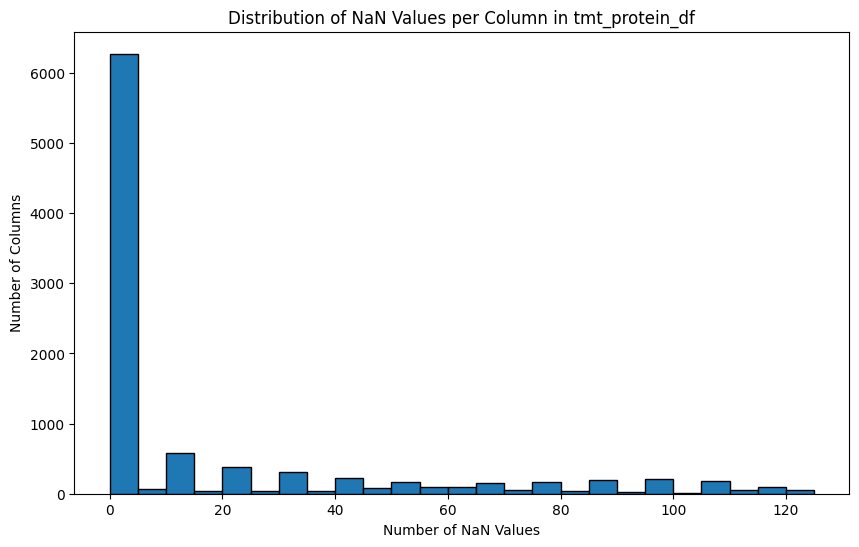

In [ ]:
tmt_protein_df.replace(0, np.nan, inplace=True)
nan_counts = tmt_protein_df.isna().sum()
num_features = tmt_protein_df.shape[1]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')  # Adjust bins as needed
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in tmt_protein_df')
plt.show()

tmt protein df new shape (130, 7557)
features removed: 2043


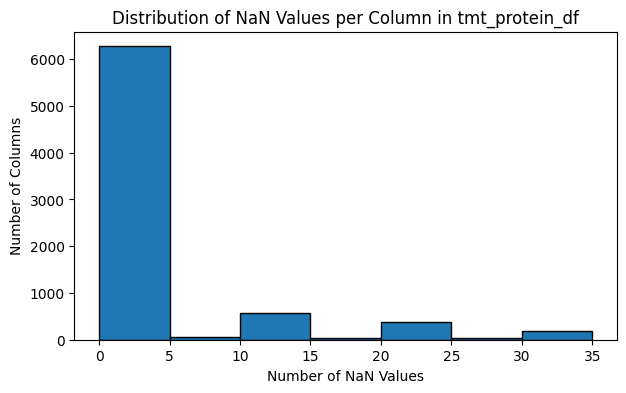

In [ ]:
# Too many sparse columns, filtering out those that have over half empty
tmt_protein_df = tmt_protein_df.loc[:, tmt_protein_df.isna().sum() <= (tmt_protein_df.shape[0]*(1-threshold))]
print("tmt protein df new shape", tmt_protein_df.shape)
print("features removed:", num_features-tmt_protein_df.shape[1])
# Count NaN values in each column
nan_counts = tmt_protein_df.isna().sum()

# Create the histogram with bins of 5
plt.figure(figsize=(7, 4))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in tmt_protein_df')
plt.xticks(range(0, int(nan_counts.max()) + 5, 5))
plt.show()

In [ ]:
X = tmt_protein_df.copy()
X = X[X.index.isin(pfs_df.index)]
train_idx = train_idx[train_idx.isin(X.index)]
test_idx = test_idx[test_idx.isin(X.index)]
print("TMT protein dataset")
print("Original number of features:", str(X.shape[1]))
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

#Step 1: impute training data
X_train_imputed = imputer.fit_transform(X_train)

# Step 2: Calculate the variance of each column in rna_seq_df and get top 5000 var columns
variances = np.var(X_train_imputed, axis=0)

# Get the indices of the top 5000 columns with the highest variance
top_6000_indices = np.argsort(variances)[::-1][:6000]
top_6000_cols = X_train.columns[top_6000_indices] #column names of top 5000 variance columns

# Get the columns with the top 5000 highest variance
X_train_imputed = X_train_imputed[:,top_6000_indices]
scaler.fit(X_train_imputed) #only fitted once?

print("X_train after selecting top 5000 variance columns", X_train_imputed.shape)

# 3. Scale and perform LassoCV
lasso = LassoCV(alphas=np.logspace(-4, 0.5, 500), cv=5, random_state=43, max_iter=5000, verbose=True)
lasso.fit(scaler.transform(X_train_imputed), y_train)

# Get the boolean mask of selected features, length 5000
mask = lasso.coef_ != 0 #sel_.get_support()
tmt_prot_alpha = lasso.alpha_
print("\nTMT Prot alpha:", tmt_prot_alpha)

# Use it to filter the original column names
selected_features = top_6000_cols[mask] #X_train.columns[mask]
print("Selected features:", selected_features.tolist())
tmt_prot_selected = X_train_imputed[:,mask]
tmt_prot_selected = pd.DataFrame(tmt_prot_selected, columns=selected_features, index=X_train.index)
tmt_prot_selected = tmt_prot_selected.add_prefix("TMT_PROT_")

X_test_ndarray = imputer.transform(X_test) #impute test data
X_test_ndarray = X_test_ndarray[:,top_6000_indices] #get top 5000 variance cols
X_test_ndarray = scaler.transform(X_test_ndarray) #scale these 5000 cols

y_pred = lasso.predict(X_test_ndarray)
tmt_prot_r2 = r2_score(y_test, y_pred)
tmt_prot_rmse = mean_squared_error(y_test, y_pred)
tmt_prot_c_index = concordance_index(y_test, -y_pred)

print("TMT Prot R2:", tmt_prot_r2)
print("TMT Prot RMSE:", tmt_prot_rmse)
print("TMT Prot C-index:", tmt_prot_c_index)

print("Num selected features:", str(len(selected_features)))

TMT protein dataset
Original number of features: 7557
X_train after selecting top 5000 variance columns (104, 6000)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


TMT Prot alpha: 2.6782783545527202
Selected features: ['EMP2', 'JPT1', 'NFIC', 'GPX4', 'CCDC86', 'GMPR2', 'BLOC1S5', 'KLC2', 'AAK1', 'DDX52']
TMT Prot R2: -0.0032419229383426895
TMT Prot RMSE: 84.19663315689496
TMT Prot C-index: 0.42765273311897106
Num selected features: 10


α = 0.5 required to reduce top 150 variance proteins to 77

α = 0.92 required to reduce features from 150 to 60

Fixed error not selecting top 150 variance columns before fitting Lasso

α = 0.3 required to reduce from 150 to 50

In [ ]:
tmt_prot_selected = tmt_protein_df.copy()[selected_features]

tmt_prot_selected_train = tmt_prot_selected.loc[train_idx]
tmt_prot_selected_test = tmt_prot_selected.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

tmt_prot_train = imputer.fit_transform(tmt_prot_selected_train)
tmt_prot_test = imputer.transform(tmt_prot_selected_test)

tmt_prot_train = scaler.fit_transform(tmt_prot_train)
tmt_prot_test = scaler.transform(tmt_prot_test)

tmt_prot_selected_train = pd.DataFrame(tmt_prot_train, columns=selected_features, index=train_idx)
tmt_prot_selected_test = pd.DataFrame(tmt_prot_test, columns=selected_features, index=test_idx)

tmt_prot_selected_train = tmt_prot_selected_train.add_prefix("TMT_PROT_")
tmt_prot_selected_test = tmt_prot_selected_test.add_prefix("TMT_PROT_")

## 4. Preprocess <u>phosphosite data</u>

In [ ]:
tmt_phosphosite_df = pd.read_csv('/content/drive/MyDrive/Masters/AIO/TMT_phosphosite.csv', index_col=0, header=0)
tmt_phosphosite_df = tmt_phosphosite_df.T
tmt_phosphosite_df = tmt_phosphosite_df[tmt_phosphosite_df.index.isin(pfs_df.index)]
num_features = tmt_phosphosite_df.shape[1]
print("pfs df shape:", pfs_df.shape)
print("tmt phosphosite df shape", tmt_phosphosite_df.shape)
tmt_phosphosite_df.head()

pfs df shape: (133, 2)
tmt phosphosite df shape (130, 41448)


,A2ML1:S698,AAAS:S495,AAGAB:S310,AAGAB:S311,AAK1:S18,AAK1:S21,AAK1:S624,AAK1:S637,AAK1:S652,AAK1:S668,...,ZYX:S344,ZYX:T274,ZZEF1:S1518,ZZEF1:S2444,ZZEF1:T2074,ZZZ3:S113,ZZZ3:S135,ZZZ3:S606,ZZZ3:S82,ZZZ3:S89
TB92-1,NaN,-0.040108,NaN,NaN,NaN,0.148313,0.262504,0.249943,-0.510226,NaN,...,-0.146746,NaN,0.255871,-0.185249,NaN,-0.212989,0.882063,-0.185799,-0.426266,-0.981518
TN28,NaN,0.095929,NaN,NaN,NaN,0.063786,0.146162,0.100510,-0.994245,NaN,...,0.257280,NaN,-0.431297,-0.781218,NaN,-0.143739,-0.542571,-0.747529,0.305754,-0.081226
TB124,NaN,-2.562917,NaN,NaN,NaN,0.493740,0.453472,-0.148856,0.226276,NaN,...,1.834959,NaN,0.449450,1.508698,NaN,0.043913,0.383161,0.469318,0.297168,-1.465814
TB69,NaN,0.110026,NaN,NaN,NaN,0.369245,0.639283,0.089904,-0.438718,NaN,...,-0.626985,NaN,0.031789,0.084088,NaN,0.050763,-0.492189,-0.369477,0.151375,-0.381728
TB115-1,NaN,0.036468,NaN,NaN,NaN,-0.019150,0.053080,0.831061,-0.389496,NaN,...,0.285579,NaN,-0.239327,-0.533289,NaN,0.298392,0.168592,0.114165,1.371242,0.377797


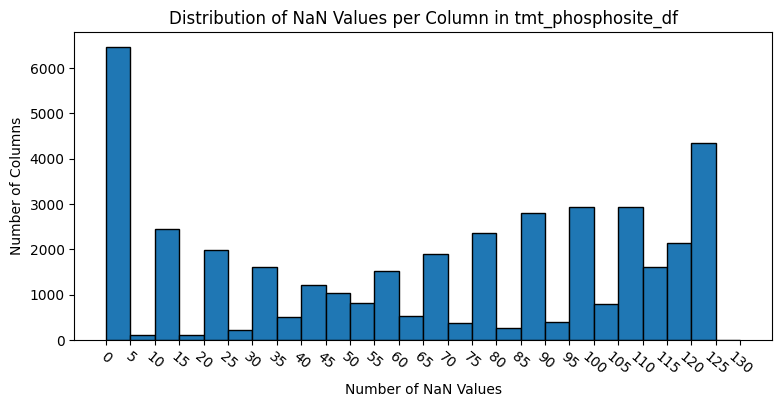

In [ ]:
# prompt: plot a histogram of the number of NaN values in each column, with bins groups of 5
tmt_phosphosite_df.replace(0, np.nan, inplace=True)
num_features = tmt_phosphosite_df.shape[1]

# Count NaN values in each column
nan_counts = tmt_phosphosite_df.isna().sum()

# Create the histogram with bins of 5
plt.figure(figsize=(9, 4))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in tmt_phosphosite_df')
plt.xticks(range(0, int(nan_counts.max()) + 5, 5), rotation=-40)
plt.show()


Original number of features: (130, 41448)
tmt phosphosite df new shape (130, 12037)
features removed: 29411


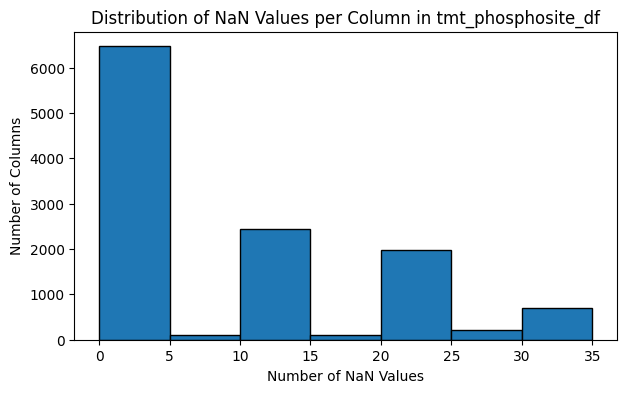

In [ ]:
# Too many sparse columns, filtering out those that have over half empty
print("Original number of features:", tmt_phosphosite_df.shape)
tmt_phosphosite_df = tmt_phosphosite_df.loc[:, tmt_phosphosite_df.isna().sum() <= (tmt_phosphosite_df.shape[0]*(1-threshold))]
print("tmt phosphosite df new shape", tmt_phosphosite_df.shape)
print("features removed:", num_features-tmt_phosphosite_df.shape[1])
# Count NaN values in each column
nan_counts = tmt_phosphosite_df.isna().sum()

# Create the histogram with bins of 5
plt.figure(figsize=(7, 4))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in tmt_phosphosite_df')
plt.xticks(range(0, int(nan_counts.max()) + 5, 5))
plt.show()

In [ ]:

#print("Original number of features:", tmt_phosphosite_df.shape)
X = tmt_phosphosite_df.copy()
X = X[X.index.isin(pfs_df.index)]
train_idx = train_idx[train_idx.isin(X.index)]
test_idx = test_idx[test_idx.isin(X.index)]
print("TMT phosphosite dataset")
print("Original number of features:", str(X.shape[1]))
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

X_train_imputed = imputer.fit_transform(X_train)

# Calculate the variance of each column in rna_seq_df
variances = np.var(X_train_imputed, axis=0)

# Get the indices of the top 150 columns with the highest variance
top_5000_indices = np.argsort(variances)[::-1][:5000]
top_5000_cols = X_train.columns[top_5000_indices] #column names of top 5000 variance columns

# Get the columns with the top 5000 highest variance
X_train_imputed = X_train_imputed[:,top_5000_indices]
scaler.fit(X_train_imputed) #only fitted once?

print("X_train after selecting top 5000 variance columns", X_train_imputed.shape)

# 3. LassoCV
lasso = LassoCV(cv=5, random_state=43, max_iter=5000, verbose=True)
lasso.fit(scaler.transform(X_train_imputed), y_train)

# Get the boolean mask of selected features, length 5000
mask = lasso.coef_ != 0 #sel_.get_support()
tmt_phospho_alpha = lasso.alpha_
print("\nTMT Phospho alpha:", tmt_phospho_alpha)

# Use it to filter the original column names
selected_features = top_5000_cols[mask] #X_train.columns[mask]
print("Num selected features:", str(len(selected_features)))
print("Selected features:", selected_features.tolist())
# tmt_phospho_selected = X_train_imputed[:,mask]
# tmt_phospho_selected = pd.DataFrame(tmt_phospho_selected, columns=selected_features, index=X_train.index)
# tmt_phospho_selected = tmt_phospho_selected.add_prefix("TMT_PHOSPHO_")

X_test_ndarray = imputer.transform(X_test) #impute test data
X_test_ndarray = X_test_ndarray[:,top_5000_indices] #get top 5000 variance cols

y_pred = lasso.predict(X_test_ndarray)
tmt_phospho_r2 = r2_score(y_test, y_pred)
tmt_phospho_rmse = mean_squared_error(y_test, y_pred)
tmt_phospho_c_index = concordance_index(y_test, -y_pred)

print("TMT Phospho R2:", tmt_phospho_r2)
print("TMT Phospho RMSE:", tmt_phospho_rmse)
print("TMT Phospho C-index:", tmt_phospho_c_index)


TMT phosphosite dataset
Original number of features: 12037
X_train after selecting top 5000 variance columns (104, 5000)


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


TMT Phospho alpha: 3.1384014412905916
Num selected features: 5
Selected features: ['ZNF629:S625', 'ZMYND11:S403', 'INTS6:S804', 'MLF2:S238', 'TLE5:S196']
TMT Phospho R2: 0.04182251891714173
TMT Phospho RMSE: 80.41461987318608
TMT Phospho C-index: 0.35691318327974275


α = 0.4 reduced features from 150 to 77

α = 0.93 reduced features from 150 to 60

After Threshold change

α = 0.88 reduced features from 150 to 60

Fixed error not selecting top 150 variance columns before fitting Lasso

α = 0.3 required to reduce from 150 to 47

In [ ]:
tmt_phosphosite_df = tmt_phosphosite_df.copy()[selected_features]

tmt_phospho_selected_train = tmt_phosphosite_df.loc[train_idx]
tmt_phospho_selected_test = tmt_phosphosite_df.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

tmt_phospho_train = imputer.fit_transform(tmt_phospho_selected_train)
tmt_phospho_test = imputer.transform(tmt_phospho_selected_test)

tmt_phospho_train = scaler.fit_transform(tmt_phospho_train)
tmt_phospho_test = scaler.transform(tmt_phospho_test)

tmt_phospho_selected_train = pd.DataFrame(tmt_phospho_train, columns=selected_features, index=train_idx)
tmt_phospho_selected_test = pd.DataFrame(tmt_phospho_test, columns=selected_features, index=test_idx)

tmt_phospho_selected_train = tmt_phospho_selected_train.add_prefix("TMT_PHOSPHO_")
tmt_phospho_selected_test = tmt_phospho_selected_test.add_prefix("TMT_PHOSPHO_")

# Concatenating all tables and training

In [ ]:
def roman_to_int(r_nums):
  roman_map = {"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5}
  int_values = [roman_map[numeral] for numeral in r_nums]
  return int_values

In [ ]:
clinical_df['Tumor Stage'] = roman_to_int(clinical_df['Tumor Stage'].str.extract(r'(^I+V?)')[0])
clinical_df['Final Stage'] = roman_to_int(clinical_df['Final Stage'].str.extract(r'(^I+V?)')[0])
clinical_df.shape

(133, 16)

In [ ]:
clinical_df_encoded = pd.get_dummies(clinical_df,drop_first=True)

# Results

## Individual lasso predictions

In [ ]:
data = {'RNA': [rna_r2, rna_rmse, rna_c_index, rna_alpha],
        'Protein': [tmt_prot_r2, tmt_prot_rmse, tmt_prot_c_index, tmt_prot_alpha],
        "Phosphosite":[tmt_phospho_r2,tmt_prot_rmse, tmt_phospho_c_index, tmt_phospho_alpha]}
lasso_results = pd.DataFrame.from_dict(data, orient='index', columns=["R2","RMSE","C-Index","Alpha"])
lasso_results

,R2,RMSE,C-Index,Alpha
RNA,-0.079204,89.800473,0.507418,1.948551
Protein,-0.003242,84.196633,0.427653,2.678278
Phosphosite,0.041823,84.196633,0.356913,3.138401


## RandomForestRegressor results

### With clinical data

In [ ]:
# prompt: combine all the tables above based on on the indices they share, and remove rows with indices that are not shared

# Combine all dataframes based on shared indices
print("clinical df:", clinical_df_encoded.shape)
print("cbc df", cbc_selected_train.shape)
print("rna df", rna_selected_train.shape)
print("tmt prot df", tmt_prot_selected_train.shape)
print("tmt phospho df", tmt_phospho_selected_train.shape)
#print("tmt acetyl df", tmt_acetyl_selected.shape)
#print(dia_prot_selected.shape) taking out DIA protein table to not mix with TMT protein table

combined_df_train = pd.concat([clinical_df_encoded, cbc_selected_train, rna_selected_train, tmt_prot_selected_train,
                        tmt_phospho_selected_train], axis=1, join='inner') #TOOK OUT CLINICAL DATA

pfs_final_train = pfs_df[pfs_df.index.isin(combined_df_train.index)]["Progression-free time (months)"]

combined_df_test = pd.concat([clinical_df_encoded, cbc_selected_test, rna_selected_test, tmt_prot_selected_test,
                        tmt_phospho_selected_test], axis=1, join='inner')

pfs_final_test = pfs_df[pfs_df.index.isin(combined_df_test.index)]["Progression-free time (months)"]

print()

print("combined df train", combined_df_train.shape)
print("pfs train", pfs_final_train.shape)

print("combined df test", combined_df_test.shape)
print("pfs test", pfs_final_test.shape)

clinical df: (133, 61)
cbc df (106, 11)
rna df (106, 16)
tmt prot df (104, 10)
tmt phospho df (104, 5)

combined df train (104, 103)
pfs train (104,)
combined df test (26, 103)
pfs test (26,)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

results = {"RMSE":[],
           "R2":[],
           "c-index":[]}

important_features = set()
importance_counts = {}
importance_sum = {}
train_count=0
for n in np.arange(100,301,10):
  print(f"n_estimators: {n}")
  train_count += 1
  model = RandomForestRegressor(
      n_estimators=n,        # number of trees (after testing in intervals of 10, 210 seemed to be the best)
      max_depth=None,          # can tune this
      random_state=42,
      n_jobs=-1                # use all processors
  )
  model.fit(combined_df_train, pfs_final_train)

  y_pred = model.predict(combined_df_test)

  rmse = mean_squared_error(np.asarray(pfs_final_test), y_pred)
  r2 = r2_score(np.asarray(pfs_final_test), y_pred)
  c_index = concordance_index(np.asarray(pfs_final_test), -y_pred)

  results["RMSE"].append(rmse)
  results["R2"].append(r2)
  results["c-index"].append(c_index)

  importances = model.feature_importances_
  feature_importances = pd.Series(importances, index=combined_df_test.columns)
  feature_importances = feature_importances.sort_values(ascending=False)
  top_20_features = feature_importances[:20]
  if n == 100:
    important_features = set(top_20_features.index)
  else:
    important_features = important_features.intersection(set(top_20_features.index))

  for feature in top_20_features.index:
        importance_counts[feature] = importance_counts.get(feature, 0) + 1
        importance_sum[feature] = importance_sum.get(feature, 0) + top_20_features[feature]

alphas = {"RNA": rna_alpha,
          "TMT prot": tmt_prot_alpha,
          "TMT phospho": tmt_phospho_alpha}
alphas_df = pd.DataFrame.from_dict(alphas, orient='index', columns=["Alpha"])
print(f"Features counts of top 20 important features across all {train_count} models")
importance_df = pd.DataFrame({'counts': importance_counts, 'sum': importance_sum}).sort_values(by='sum', ascending=False)
importance_df["avg relative importance"] = importance_df["sum"]/train_count
print()
metrics_df = pd.DataFrame(results, index=np.arange(100,301,10))
metrics_df.index.name = "n_estimators"
metrics_df = metrics_df.T
metrics_df.style.background_gradient(axis=1).format(precision=2)

n_estimators: 100
n_estimators: 110
n_estimators: 120
n_estimators: 130
n_estimators: 140
n_estimators: 150
n_estimators: 160
n_estimators: 170
n_estimators: 180
n_estimators: 190
n_estimators: 200
n_estimators: 210
n_estimators: 220
n_estimators: 230
n_estimators: 240
n_estimators: 250
n_estimators: 260
n_estimators: 270
n_estimators: 280
n_estimators: 290
n_estimators: 300
Features counts of top 20 important features across all 21 models



n_estimators,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300
RMSE,92.15,92.43,92.86,90.10,89.80,90.64,89.20,87.99,87.39,87.38,87.64,88.26,87.05,87.65,87.52,88.04,88.55,88.29,88.16,87.90,87.31
R2,-0.10,-0.10,-0.11,-0.07,-0.07,-0.08,-0.06,-0.05,-0.04,-0.04,-0.04,-0.05,-0.04,-0.04,-0.04,-0.05,-0.06,-0.05,-0.05,-0.05,-0.04
c-index,0.46,0.46,0.45,0.44,0.44,0.45,0.43,0.43,0.44,0.43,0.45,0.45,0.43,0.44,0.44,0.45,0.45,0.46,0.44,0.44,0.44


In [ ]:
importance_df

,counts,sum,avg relative importance
TMT_PROT_GMPR2,21,2.021999,0.096286
RNA_KLF5,21,1.335834,0.063611
Stromal Score Estimate,21,1.088428,0.051830
RNA_CCL11,21,1.080008,0.051429
RNA_PPP1R35,21,0.800481,0.038118
Th1_cells_xcell,21,0.702716,0.033463
Osteoblast_xcell,21,0.692729,0.032987
Tumor Size (cm),21,0.681371,0.032446
Macrophages_M1_xcell,21,0.592411,0.028210
RNA_NOP10,21,0.556177,0.026485


<u>Best results</u>

n_estimators: 210

RMSE: 78.59

R^2: 0.06

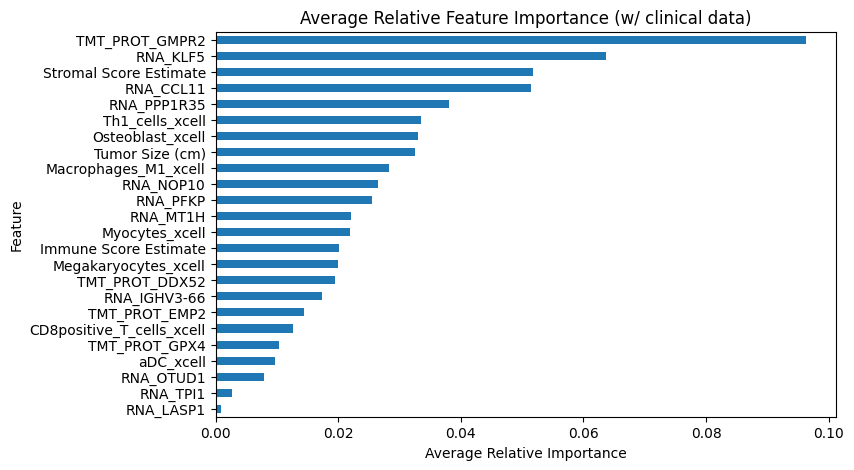

In [ ]:
# prompt: make a horizontal bar chart of the avg relative importance column in importance_df

importance_df["avg relative importance"][::-1].plot(kind='barh', figsize=(8, 5))
plt.xlabel("Average Relative Importance")
plt.ylabel("Feature")
plt.title("Average Relative Feature Importance (w/ clinical data)")
plt.show()


In [ ]:
# prompt: from the top 50 values in feature_importances, count the number of indices within the following groups...
# starts with "TMT_PHOSPHO"
# starts with "RNA"
# starts with "TMT_ACETYL"
# starts with "CBC"
# starts with "TMT_PROT"
# starts with anything else
# also take the sums of each group
# then sort the counts and sums in descending order
# make the sums and the counts in 2 separate dictionaries
# then print each pair of the dictionaries on a new line
# print each dictionary separately

import pandas as pd

top_features = feature_importances[:20]

counts = {"TMT_PHOSPHO": 0, "RNA": 0, "TMT_ACETYL": 0, "CBC": 0, "TMT_PROT": 0, "other": 0}
sums = {"TMT_PHOSPHO": 0, "RNA": 0, "TMT_ACETYL": 0, "CBC": 0, "TMT_PROT": 0, "other": 0}

for feature, importance in top_features.items():
    if feature.startswith("TMT_PHOSPHO"):
        counts["TMT_PHOSPHO"] += 1
        sums["TMT_PHOSPHO"] += importance
    elif feature.startswith("RNA"):
        counts["RNA"] += 1
        sums["RNA"] += importance
    elif feature.startswith("TMT_ACETYL"):
        counts["TMT_ACETYL"] += 1
        sums["TMT_ACETYL"] += importance
    elif feature.startswith("CBC"):
        counts["CBC"] += 1
        sums["CBC"] += importance
    elif feature.startswith("TMT_PROT"):
        counts["TMT_PROT"] += 1
        sums["TMT_PROT"] += importance
    else:
        counts["other"] += 1
        sums["other"] += importance

sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
sorted_sums = dict(sorted(sums.items(), key=lambda item: item[1], reverse=True))

print("Counts:")
for key, value in sorted_counts.items():
    print(f"{key}: {value}")
print("\nSums:")
for key, value in sorted_sums.items():
    print(f"{key}: {value}")


Counts:
other: 10
RNA: 8
TMT_PROT: 2
TMT_PHOSPHO: 0
TMT_ACETYL: 0
CBC: 0

Sums:
other: 0.27855126445329065
RNA: 0.2679944579030473
TMT_PROT: 0.11289988947198902
TMT_PHOSPHO: 0
TMT_ACETYL: 0
CBC: 0


In [ ]:
feature_importances[feature_importances == 0].index.to_list()

['Dominant HPV_HPV45',
 'HPV_HPV45',
 'Dominant HPV_HPV53',
 'Vaginal Secretion_Candida Glabrata',
 'Vaginal Secretion_Candida Tropicalis']

### Without clinical data (only omics data)

In [ ]:
# now train models, but without considering cbc or clinical data (only omics)
print("rna df", rna_selected_train.shape)
print("tmt prot df", tmt_prot_selected_train.shape)
print("tmt phospho df", tmt_phospho_selected_train.shape)

combined_df_train = pd.concat([rna_selected_train, tmt_prot_selected_train,
                        tmt_phospho_selected_train], axis=1, join='inner') #TOOK OUT CLINICAL DATA

pfs_final_train = pfs_df[pfs_df.index.isin(combined_df_train.index)]["Progression-free time (months)"]

combined_df_test = pd.concat([rna_selected_test, tmt_prot_selected_test,
                        tmt_phospho_selected_test], axis=1, join='inner')

pfs_final_test = pfs_df[pfs_df.index.isin(combined_df_test.index)]["Progression-free time (months)"]

print()

print("combined df train", combined_df_train.shape)
print("pfs train", pfs_final_train.shape)

print("combined df test", combined_df_test.shape)
print("pfs test", pfs_final_test.shape)

results = {"RMSE":[],
           "R2":[],
           "c-index":[]}

important_features = set()
importance_counts = {}
importance_sum = {}
train_count=0

for n in np.arange(100,301,10):
  print(f"n_estimators: {n}")
  train_count += 1
  model = RandomForestRegressor(
      n_estimators=n,        # number of trees (after testing in intervals of 10, 210 seemed to be the best)
      max_depth=None,          # can tune this
      random_state=42,
      n_jobs=-1                # use all processors
  )
  model.fit(combined_df_train, pfs_final_train)

  y_pred = model.predict(combined_df_test)

  rmse = mean_squared_error(np.asarray(pfs_final_test), y_pred)
  r2 = r2_score(np.asarray(pfs_final_test), y_pred)
  c_index = concordance_index(np.asarray(pfs_final_test), -y_pred)

  results["RMSE"].append(rmse)
  results["R2"].append(r2)
  results["c-index"].append(c_index)

  importances = model.feature_importances_
  feature_importances = pd.Series(importances, index=combined_df_test.columns)
  feature_importances = feature_importances.sort_values(ascending=False)

  top_20_features = feature_importances[:20]
  if n == 100:
    important_features = set(top_20_features.index)
  else:
    important_features = important_features.intersection(set(top_20_features.index))

  for feature in top_20_features.index:
        importance_counts[feature] = importance_counts.get(feature, 0) + 1
        importance_sum[feature] = importance_sum.get(feature, 0) + top_20_features[feature]

importance_df_no_clin = pd.DataFrame({'counts': importance_counts, 'sum': importance_sum}).sort_values(by='sum', ascending=False)
importance_df_no_clin["avg relative importance"] = importance_df_no_clin["sum"]/train_count

metrics_df_no_clin = pd.DataFrame(results, index=np.arange(100,301,10)).T
metrics_df_no_clin.index.name = "n_estimators"
metrics_df_no_clin.style.background_gradient(axis=1).format(precision=2)

rna df (106, 16)
tmt prot df (104, 10)
tmt phospho df (104, 5)

combined df train (104, 31)
pfs train (104,)
combined df test (26, 31)
pfs test (26,)
n_estimators: 100
n_estimators: 110
n_estimators: 120
n_estimators: 130
n_estimators: 140
n_estimators: 150
n_estimators: 160
n_estimators: 170
n_estimators: 180
n_estimators: 190
n_estimators: 200
n_estimators: 210
n_estimators: 220
n_estimators: 230
n_estimators: 240
n_estimators: 250
n_estimators: 260
n_estimators: 270
n_estimators: 280
n_estimators: 290
n_estimators: 300


,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300
n_estimators,,,,,,,,,,,,,,,,,,,,,
RMSE,77.29,78.11,76.61,77.43,76.59,76.43,74.91,76.03,75.76,75.33,75.29,74.66,76.02,75.67,75.20,75.14,75.52,76.13,76.47,76.98,77.14
R2,0.08,0.07,0.09,0.08,0.09,0.09,0.11,0.09,0.10,0.10,0.10,0.11,0.09,0.10,0.10,0.10,0.10,0.09,0.09,0.08,0.08
c-index,0.41,0.43,0.40,0.40,0.42,0.40,0.38,0.40,0.40,0.38,0.38,0.38,0.40,0.41,0.40,0.40,0.40,0.41,0.41,0.42,0.42


In [ ]:
importance_df_no_clin

,counts,sum,avg relative importance
TMT_PROT_JPT1,21,1.728811,0.082324
TMT_PHOSPHO_ZMYND11:S403,21,1.639896,0.078090
RNA_NOP10,21,1.579505,0.075215
TMT_PROT_DDX52,21,1.343827,0.063992
TMT_PROT_CCDC86,21,1.214259,0.057822
RNA_CCL11,21,1.031736,0.049130
TMT_PHOSPHO_ZNF629:S625,21,0.909664,0.043317
RNA_IGHV3-66,21,0.875128,0.041673
RNA_RAB5C,21,0.687475,0.032737
RNA_KLF5,21,0.684507,0.032596


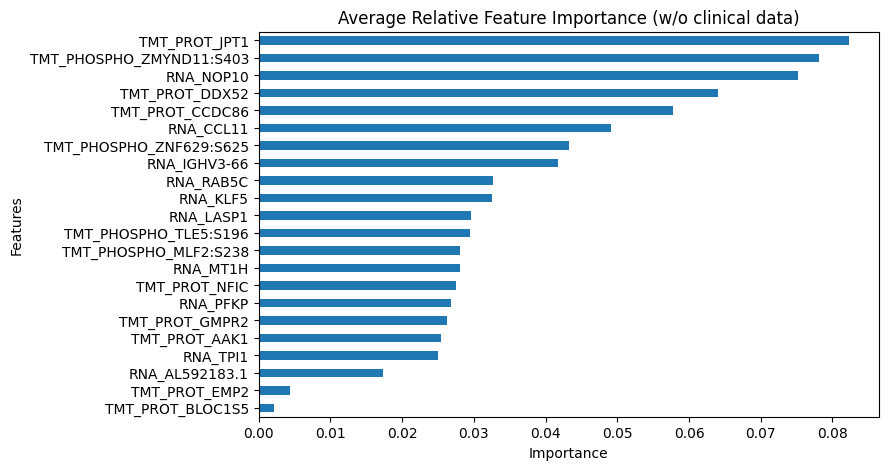

In [ ]:
plt.figure(figsize=(8, 5))
importance_df_no_clin["avg relative importance"][::-1].plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Average Relative Feature Importance (w/o clinical data)") # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
combined_results = pd.concat([metrics_df, metrics_df_no_clin], keys=["w/ clinical data", "w/o clinical data"])
combined_results.style.background_gradient(axis=1).format(precision=2)

### First set of results (before catching error not filtering data correctly with variance thresholding)

<h2>First run</h2>
<u>Initial results</u>

* RMSE: 90.91
* R<sup>2</sup>: -0.08

<u>Lasso α for each dataset</u>
* CBC: NA (67 features)
* RNA: 0.5 (77 features)
* TMT Protein: 0.5 (77 features)
* TMT Phosphosite: 0.4 (77 features)
* TMT Acetylsite: 0.4 (71 features)

<h2>2nd run</h2>

* RMSE: 84.08
* R<sup>2</sup>: 0

<u>Lasso α for each dataset</u>
* CBC: NA (67 features)
* RNA: 0.87 (60 features)
* TMT Protein: 0.92 (60 features)
* TMT Phosphosite: 0.93 (60 features)
* TMT Acetylsite: 0.57 (60 features)

**Group ID shown to have 0 importance**

<h2>3rd run</h2>

* RMSE: 82.88
* ${R^2}$: 0.01
* RNA alpha: 0.87
* TMT prot alpha: 0.92
* TMT phospho alpha: 0.93
* TMT acetyl alpha: 0.57

**HPV shown to have little to no importance**

<h2>4th run</h2> (after removing HPV columns)

* RMSE: 84.14
* R^2: -0.00
* RNA alpha: 0.87
* TMT prot alpha: 0.92
* TMT phospho alpha: 0.93
* TMT acetyl alpha: 0.57

Vaginal secretion shown to have no importance, so will restore HPV columns and remove Vaginal secration column

<h2>5th run</h2>
(After restoring HPV cols and removing Vaginal Secretion col)

* RMSE: 82.70
* R^2: 0.01
* RNA alpha: 0.87
* TMT prot alpha: 0.92
* TMT phospho alpha: 0.93
* TMT acetyl alpha: 0.57

<h2>6th run</h2>

(Removed Histological Diagnosis, still saw that HPV was not important)

* RMSE: 83.92
* R^2: 0.00
* RNA alpha: 0.87
* TMT prot alpha: 0.92
* TMT phospho alpha: 0.93
* TMT acetyl alpha: 0.57

(Now will restore Histological diagnosis and remove only 1 HPV column)

<h2>7th run</h2>

(Removed HPV col but worse performance)

* RMSE: 85.33
* R^2: -0.02
* RNA alpha: 0.87
* TMT prot alpha: 0.92
* TMT phospho alpha: 0.93
* TMT acetyl alpha: 0.57

<h2>8th run</h2>

(Added back HPV col, and increased threshold for min data required to keep column in omics dataset from 50% to 75%)

* RMSE: 87.73
* R^2: -0.05
* RNA alpha: 0.87
* TMT prot alpha: 0.92
* TMT phospho alpha: 0.93
* TMT acetyl alpha: 0.57

Keeping alphas the same after threshold changed reduced number of columns. Will decrease alpha to keep same number of columns (60)

<h2>9th run</h2>

* RMSE: 92.07
* R^2: -0.10
* RNA alpha: 0.84
* TMT prot alpha: 0.92
* TMT phospho alpha: 0.88
* TMT acetyl alpha: 0.39



![](https://i.ibb.co/zTFyR1Nj/most-important-features.png)

![](https://i.ibb.co/FLJ5dHHs/image.png)

<h2>First run after error</h2>

* clinical df: (133, 61)
* cbc df (106, 53)
* rna df (106, 49)
* tmt prot df (104, 50)
* tmt phospho df (104, 47)
* tmt acetyl df (104, 47)
* combined df train (104, 307)
* pfs train (104,)
* combined df test (26, 307)
* pfs test (26,)

will try to remove "HPV" (not dominant) again

# Try again with RFECV

## 2. Preprocess <u>RNA seq</u> data

In [ ]:
rna_seq_df = pd.read_csv('/content/drive/MyDrive/Masters/AIO/rna_seq.csv', index_col=0, header=0).T #take transpose of data, put samples in rows and RNA seq in columns
print("Original RNA seq", rna_seq_df.shape)
rna_seq_df = rna_seq_df[rna_seq_df.index.isin(pfs_df.index)]
print("pfs df shape:", pfs_df.shape)
print("rna seq shape", rna_seq_df.shape)
rna_seq_df.head()


Original RNA seq (161, 24595)
pfs df shape: (133, 2)
rna seq shape (133, 24595)


gene name,AL627309.1,AL627309.5,LINC01409,FAM87B,LINC01128,LINC00115,AL645608.6,AL645608.2,LINC02593,SAMD11,...,AL592183.1,AC240274.1,AC213203.2,AC004556.3,AC233755.2,AC233755.1,AC136616.1,AC141272.1,AC007325.4,AC007325.2
TB100-1,0.096448,0.792359,3.872883,1.384309,3.668036,15.053190,0.341279,0.000000,0.173105,0.875523,...,117.856754,34.558548,1.081127,42.816414,2.444670,1.365115,0.098188,0.000000,3.209511,31.379195
TB101-1,0.359360,2.012917,8.659514,2.469514,6.874064,12.431307,9.016677,26.621123,62.035258,81.047998,...,61.189787,43.842594,1.391563,80.601780,0.000000,0.000000,30.348139,0.000000,12.292934,26.951616
TB102-1,0.244301,1.642892,1.777530,1.669721,3.121759,8.047144,1.296674,1.111070,3.570405,7.556719,...,45.618133,11.162545,0.000000,0.351454,8.846115,52.978402,0.497413,0.000000,3.805726,16.275013
TB104-1,0.438349,1.005853,3.440943,1.388483,4.594914,10.947614,0.481370,0.684802,5.208818,12.065753,...,84.177719,27.026289,0.338871,0.456651,4.980711,15.082941,0.030776,1.173341,6.175273,191.887277
TB105-1,0.439860,0.627220,2.344650,1.954099,5.296762,8.177699,4.669281,2.808342,1.437944,2.286327,...,32.098617,9.582799,0.281746,0.553688,27.474567,35.353128,0.511762,1.219433,4.101637,17.912732


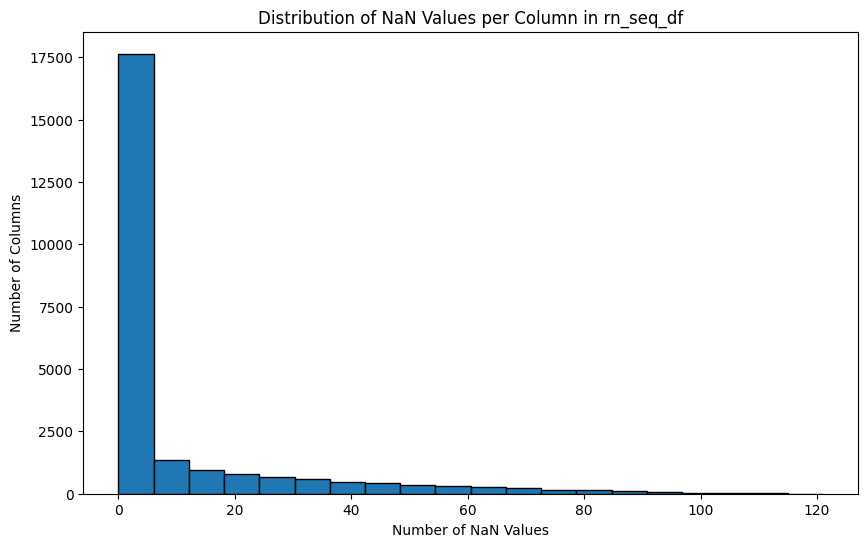

In [ ]:
# Count NaN values in each column
rna_seq_df.replace(0, np.nan, inplace=True)
nan_counts = rna_seq_df.isna().sum()
num_features = rna_seq_df.shape[1]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(nan_counts, bins=20, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in rn_seq_df')
plt.show()

rna seq df new shape (133, 21683)
features removed: 2912


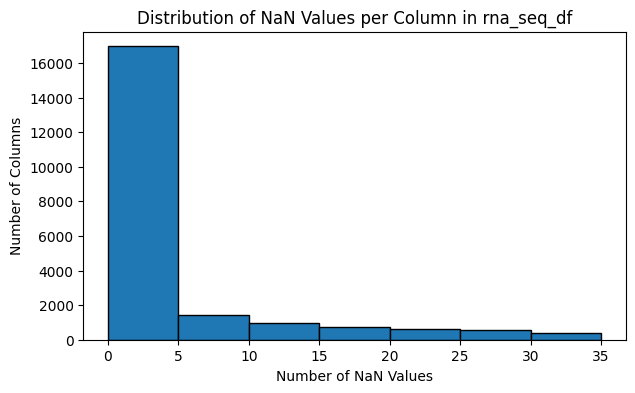

In [ ]:
#threshold = 0.75  # 75% OF DATA MUST BE PRESENT IN COLUMN TO BE CONSIDERED
rna_seq_df = rna_seq_df.loc[:, rna_seq_df.isna().sum() <= (rna_seq_df.shape[0]*(1-threshold))]
print("rna seq df new shape", rna_seq_df.shape)
print("features removed:", num_features-rna_seq_df.shape[1])
# Count NaN values in each column
nan_counts = rna_seq_df.isna().sum()

# Create the histogram with bins of 5
plt.figure(figsize=(7, 4))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in rna_seq_df')
plt.xticks(range(0, int(nan_counts.max()) + 5, 5))
plt.show()

In [ ]:
# prompt: create a histogram of the variance of the columns in rna_seq and set the y scale to log. Also save the top 100 columns with highest variance as a new dataframe

X = rna_seq_df.copy()
X = X[X.index.isin(pfs_df.index)]
train_idx = train_idx[train_idx.isin(X.index)]
test_idx = test_idx[test_idx.isin(X.index)]
print("RNA Seq dataset")
print("Original number of features:", str(X.shape[1]))
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

X_train_rna = imputer.fit_transform(X_train)

# Calculate the variance of each column in rna_seq_df
variances = np.var(X_train_imputed, axis=0)

var_cutoffs = np.arange(20,4001,40)
for n in var_cutoffs:
  print("testing with",n,"cutoff")
  # # Get the indices of the top 5000 columns with the highest variance
  top_indices = np.argsort(variances)[::-1][:n]
  top_cols = X_train.columns[top_indices] #column names of top 5000 variance columns

  # # Get the columns with the top n highest variance
  X_train_imputed = X_train_rna[:,top_indices]
  scaler.fit(X_train_imputed) #only fitted once?

  #print("X_train after selecting top 5000 variance columns", X_train_imputed.shape)

  estimator = Lasso()

  selector = RFECV(
      cv=5,
      estimator=estimator,
      scoring='r2',  # or 'r2', etc.
      n_jobs=1,
      step=10,
  )

  selector.fit(scaler.transform(X_train_imputed), y_train)
  # Get the boolean mask of selected features, length 5000
  mask = selector.support_
  selected_features = top_cols[mask]
  print("Num selected features:", str(len(selected_features)))
  print("Selected features:", selected_features.tolist())
  print()
# Use it to filter the original column names
#selected_features = X_train[mask] #X_train.columns[mask]
# rna_selected = X_train_imputed[:,mask]
# rna_selected = pd.DataFrame(rna_selected, columns=selected_features, index=X_train.index)
# rna_selected = rna_selected.add_prefix("RNA_")

# X_test_ndarray = imputer.transform(X_test) #impute test data
# X_test_ndarray = X_test_ndarray[:,top_7600_indices] #get top 5000 variance cols
# X_test_ndarray = scaler.transform(X_test_ndarray) #scale these 5000 cols

# X_test_ndarray = X_test_ndarray[:,mask] #mask to get features selected by Lasso model
# rna_selected_test = pd.DataFrame(X_test_ndarray, columns=selected_features, index=X_test.index)
# rna_selected_test = rna_selected_test.add_prefix("RNA_")

#print("Num selected features:", str(len(selected_features)))


RNA Seq dataset
Original number of features: 21683
testing with 20 cutoff
Num selected features: 1
Selected features: ['AL390719.2']

testing with 60 cutoff
Num selected features: 40
Selected features: ['AL390719.2', 'LINC01770', 'FNDC10', 'LINC01786', 'PLEKHN1', 'SLC35E2A', 'ATAD3B', 'LINC00115', 'SLC35E2B', 'C1orf159', 'SCNN1D', 'ISG15', 'SSU72', 'TAS1R3', 'AL645608.7', 'VWA1', 'MIB2', 'RNF223', 'AL645608.1', 'CPTP', 'NOC2L', 'UBE2J2', 'AL645728.1', 'ACAP3', 'DVL1', 'AGRN', 'MRPL20-AS1', 'SAMD11', 'TMEM88B', 'ATAD3A', 'LINC02593', 'AL645608.2', 'ANKRD65', 'AL391244.2', 'PUSL1', 'AL390719.3', 'AURKAIP1', 'KLHL17', 'MRPL20', 'AL627309.5']

testing with 100 cutoff
Num selected features: 57
Selected features: ['CCNL2', 'AL391244.1', 'ATAD3C', 'AL390719.2', 'LINC01770', 'MMP23B', 'AL162741.1', 'PERM1', 'LINC01409', 'TNFRSF18', 'FNDC10', 'LINC01786', 'TNFRSF4', 'LINC01128', 'PLEKHN1', 'SLC35E2A', 'ATAD3B', 'LINC00115', 'SLC35E2B', 'C1orf159', 'SCNN1D', 'ISG15', 'SSU72', 'TAS1R3', 'AL645608

In [ ]:
rna_selection = selected_features.copy()
rna_selection

Index(['CCNL2', 'AL391244.1', 'ATAD3C', 'AL390719.2', 'LINC01770', 'MMP23B',
       'AL162741.1', 'PERM1', 'LINC01409', 'TNFRSF18', 'FNDC10', 'LINC01786',
       'TNFRSF4', 'LINC01128', 'PLEKHN1', 'SLC35E2A', 'ATAD3B', 'LINC00115',
       'SLC35E2B', 'C1orf159', 'SCNN1D', 'ISG15', 'SSU72', 'TAS1R3',
       'AL645608.7', 'VWA1', 'MIB2', 'RNF223', 'AL645608.1', 'CPTP', 'NOC2L',
       'UBE2J2', 'AL645728.1', 'ACAP3', 'DVL1', 'AGRN', 'MRPL20-AS1', 'SAMD11',
       'TMEM88B', 'ATAD3A', 'LINC02593', 'AL645608.2', 'ANKRD65', 'AL391244.2',
       'PUSL1', 'AL390719.3', 'AURKAIP1', 'KLHL17', 'MRPL20', 'AL627309.5',
       'INTS11', 'TMEM240', 'TTLL10', 'AL139287.1', 'SDF4', 'AL645608.8',
       'AL691432.4'],
      dtype='object', name='gene name')

In [ ]:
rna_selected = rna_seq_df.copy()[rna_selection]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

imputer.fit(rna_selected.loc[train_idx])
rna_selected_train = imputer.transform(rna_selected.loc[train_idx])
rna_selected_test = imputer.transform(rna_selected.loc[test_idx])

scaler.fit(rna_selected_train)
rna_selected_train = pd.DataFrame(scaler.transform(rna_selected_train), columns=rna_selected.columns, index=train_idx)
rna_selected_train = rna_selected_train.add_prefix("RNA_")

rna_selected_test = pd.DataFrame(scaler.transform(rna_selected_test), columns=rna_selected.columns, index=test_idx)
rna_selected_test = rna_selected_test.add_prefix("RNA_")

Seems to converge on this set of RNA with multiple variance threshold cutoffs

['TTLL10', 'AC096540.1', 'TAL1', 'LINC01748', 'HHLA3', 'LRRIQ3', 'GSTM5',
       'FAM72C', 'TXNIP', 'AL162431.1']


['MIB2', 'TAS1R3', 'ANKRD65', 'ISG15', 'AURKAIP1', 'LINC01770', 'TTLL10',
       'AL390719.2', 'AL645728.1', 'SCNN1D', 'CDK11B', 'AL691432.4',
       'AL139287.1', 'ATAD3B', 'LINC01128', 'AL645608.8', 'CDK11A', 'RNF223',
       'PERM1', 'AL627309.1', 'SSU72', 'NADK', 'LINC01409', 'B3GALT6', 'DVL1',
       'SLC35E2B', 'CPTP']

['ISG15', 'AL645608.8', 'AL390719.2', 'TTLL10', 'SCNN1D', 'TAS1R3', 'AURKAIP1', 'ANKRD65', 'LINC01770', 'MIB2']

57 features: ['CCNL2', 'AL391244.1', 'ATAD3C', 'AL390719.2', 'LINC01770', 'MMP23B',
       'AL162741.1', 'PERM1', 'LINC01409', 'TNFRSF18', 'FNDC10', 'LINC01786',
       'TNFRSF4', 'LINC01128', 'PLEKHN1', 'SLC35E2A', 'ATAD3B', 'LINC00115',
       'SLC35E2B', 'C1orf159', 'SCNN1D', 'ISG15', 'SSU72', 'TAS1R3',
       'AL645608.7', 'VWA1', 'MIB2', 'RNF223', 'AL645608.1', 'CPTP', 'NOC2L',
       'UBE2J2', 'AL645728.1', 'ACAP3', 'DVL1', 'AGRN', 'MRPL20-AS1', 'SAMD11',
       'TMEM88B', 'ATAD3A', 'LINC02593', 'AL645608.2', 'ANKRD65', 'AL391244.2',
       'PUSL1', 'AL390719.3', 'AURKAIP1', 'KLHL17', 'MRPL20', 'AL627309.5',
       'INTS11', 'TMEM240', 'TTLL10', 'AL139287.1', 'SDF4', 'AL645608.8',
       'AL691432.4']


## 3. Preprocess TMT Protein Data

In [ ]:
tmt_protein_df = pd.read_csv('/content/drive/MyDrive/Masters/AIO/TMT_protein.csv', index_col=0, header=0)
print("Original protein table:", tmt_protein_df.shape)
tmt_protein_df = tmt_protein_df.T
tmt_protein_df = tmt_protein_df[tmt_protein_df.index.isin(pfs_df.index)]
print("pfs df shape:", pfs_df.shape)
print("tmt protein df shape", tmt_protein_df.shape)
tmt_protein_df.head()

Original protein table: (9600, 169)
pfs df shape: (133, 2)
tmt protein df shape (130, 9600)


,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,...,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,MIEF1,WIZ
TB92-1,1.109105,-1.350925,-7.352262,NaN,0.348523,-0.771129,-1.216894,-0.881949,1.956431,0.597282,...,-0.515271,-1.426691,NaN,NaN,-0.622825,-0.260715,-0.011575,-0.821564,-0.023820,-0.023917
TN28,1.165010,-0.538794,-2.087807,NaN,0.171785,0.614586,1.165821,0.421518,-1.020034,0.161342,...,0.491049,0.184299,NaN,NaN,0.554543,-0.036960,-0.694632,-0.840372,0.065202,0.064909
TB124,3.280801,2.219759,-0.730076,NaN,0.233653,1.287370,-0.458528,-0.102209,0.074090,-1.016907,...,-0.125049,0.693394,NaN,NaN,1.053595,-0.156822,1.490633,-0.590193,0.038025,0.038024
TB69,-0.143996,0.999270,3.889919,NaN,0.199872,1.268369,-0.061389,1.116271,-0.099858,-0.546449,...,0.290976,0.376577,NaN,NaN,NaN,-0.001999,-0.117368,-0.719367,-0.004887,-0.005166
TB115-1,-0.259212,1.265590,-4.623181,NaN,0.294399,-0.693925,-0.408865,-0.081995,-1.279644,-1.655624,...,0.319784,0.822631,NaN,NaN,0.795055,-0.022979,-0.432905,0.657520,-0.054690,-0.054877


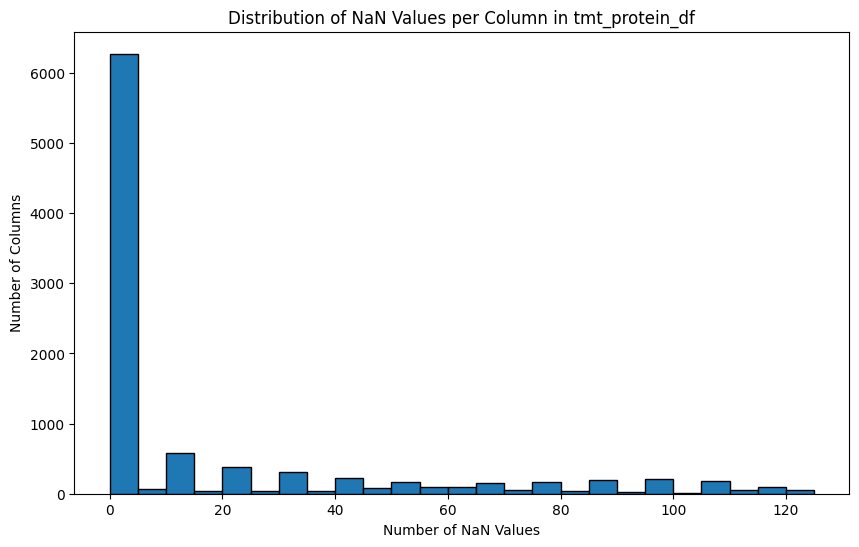

In [ ]:
tmt_protein_df.replace(0, np.nan, inplace=True)
nan_counts = tmt_protein_df.isna().sum()
num_features = tmt_protein_df.shape[1]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')  # Adjust bins as needed
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in tmt_protein_df')
plt.show()

tmt protein df new shape (130, 7557)
features removed: 2043


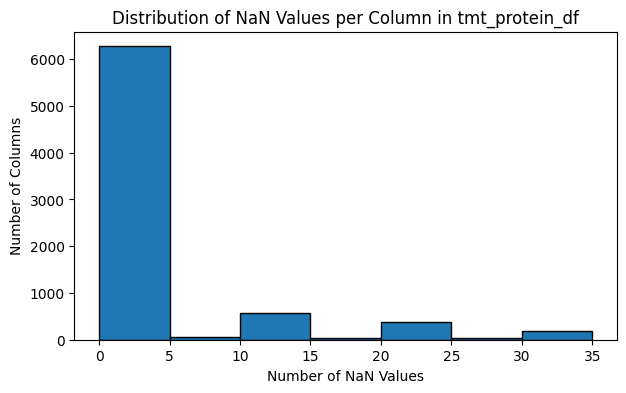

In [ ]:
# Too many sparse columns, filtering out those that have over half empty
tmt_protein_df = tmt_protein_df.loc[:, tmt_protein_df.isna().sum() <= (tmt_protein_df.shape[0]*(1-threshold))]
print("tmt protein df new shape", tmt_protein_df.shape)
print("features removed:", num_features-tmt_protein_df.shape[1])
# Count NaN values in each column
nan_counts = tmt_protein_df.isna().sum()

# Create the histogram with bins of 5
plt.figure(figsize=(7, 4))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in tmt_protein_df')
plt.xticks(range(0, int(nan_counts.max()) + 5, 5))
plt.show()

In [ ]:
X = tmt_protein_df.copy()
X = X[X.index.isin(pfs_df.index)]
train_idx = train_idx[train_idx.isin(X.index)]
test_idx = test_idx[test_idx.isin(X.index)]
print("TMT protein dataset")
print("Original number of features:", str(X.shape[1]))
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

#Step 1: impute training data
X_train_imputed = imputer.fit_transform(X_train)

# # Step 2: Calculate the variance of each column in rna_seq_df and get top 5000 var columns
variances = np.var(X_train_imputed, axis=0)

# Get the indices of the top 5000 columns with the highest variance
top_6000_indices = np.argsort(variances)[::-1][:6000]
top_6000_cols = X_train.columns[top_6000_indices] #column names of top 5000 variance columns

# # # Get the columns with the top 5000 highest variance
X_train_imputed = X_train_imputed[:,top_6000_indices]
scaler.fit(X_train_imputed) #only fitted once?

estimator = Lasso()

selector = RFECV(
    cv=5,
    estimator=estimator,
    scoring='r2',  # or 'r2', etc.
    n_jobs=1,
    step=10,
    verbose=1,
    #min_features_to_select = 20
)
selector.fit(scaler.transform(X_train_imputed), y_train)
# Get the boolean mask of selected features, length 5000
mask = selector.support_

# Use it to filter the original column names
selected_features = top_6000_cols[mask]
#selected_features = X_train.columns[mask]
print("Selected features:", selected_features.tolist())
tmt_prot_selected = X_train_imputed[:,mask]
tmt_prot_selected = pd.DataFrame(tmt_prot_selected, columns=selected_features, index=X_train.index)
tmt_prot_selected = tmt_prot_selected.add_prefix("TMT_PROT_")

X_test_ndarray = imputer.transform(X_test) #impute test data
X_test_ndarray = X_test_ndarray[:,top_6000_indices] #get top 5000 variance cols
X_test_ndarray = scaler.transform(X_test_ndarray) #scale these 5000 cols

# r2 = r2_score(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred)

# print("TMT Prot R2:", r2)
# print("TMT Prot RMSE:", rmse)

X_test_ndarray = X_test_ndarray[:,mask] #mask to get features selected by Lasso model
tmt_prot_selected_test = pd.DataFrame(X_test_ndarray, columns=selected_features, index=X_test.index)
tmt_prot_selected_test = tmt_prot_selected_test.add_prefix("TMT_PROT_")

print("Num selected features:", str(len(selected_features)))

TMT protein dataset
Original number of features: 7557
Fitting estimator with 6000 features.
Fitting estimator with 5990 features.
Fitting estimator with 5980 features.
Fitting estimator with 5970 features.
Fitting estimator with 5960 features.
Fitting estimator with 5950 features.
Fitting estimator with 5940 features.
Fitting estimator with 5930 features.
Fitting estimator with 5920 features.
Fitting estimator with 5910 features.
Fitting estimator with 5900 features.
Fitting estimator with 5890 features.
Fitting estimator with 5880 features.
Fitting estimator with 5870 features.
Fitting estimator with 5860 features.
Fitting estimator with 5850 features.
Fitting estimator with 5840 features.
Fitting estimator with 5830 features.
Fitting estimator with 5820 features.
Fitting estimator with 5810 features.
Fitting estimator with 5800 features.
Fitting estimator with 5790 features.
Fitting estimator with 5780 features.
Fitting estimator with 5770 features.
Fitting estimator with 5760 featur

**WORKS FINE WHEN FILTERING TOP 6000 HIGHEST VARIANCE COLUMNS FIRST, BUT NOT WHEN CONSIDERING ALL OR AFTER FILTERING SPARSE COLUMNS?**

In [ ]:
protein_selection = selected_features.copy()
protein_selection

Index(['HBZ', 'IGHG4', 'SPINT2', 'ARHGAP42', 'EMP2', 'GPSM3', 'AFM', 'ADGRL2',
       'LSM7', 'IGHV1-46', 'JPT1', 'GALNS', 'GYG1', 'GPX4', 'IGF1R', 'MCCC2',
       'PYROXD1', 'PDK1', 'CCDC86', 'ZNF865', 'PIK3R2', 'CCDC88C', 'NDUFAF1',
       'PGAM5', 'FMNL3', 'NRBF2', 'HACD4', 'VWA8', 'GMPR2', 'L3MBTL3',
       'AASDHPPT', 'KLC2', 'RBFA', 'TP53BP2', 'SLC25A26', 'POLR3C', 'MRPS12',
       'CHMP3', 'AAK1', 'DDX52'],
      dtype='object')

['HBZ', 'IGHG4', 'SPINT2', 'ARHGAP42', 'EMP2', 'GPSM3', 'AFM', 'ADGRL2',
       'LSM7', 'IGHV1-46', 'JPT1', 'GALNS', 'GYG1', 'GPX4', 'IGF1R', 'MCCC2',
       'PYROXD1', 'PDK1', 'CCDC86', 'ZNF865', 'PIK3R2', 'CCDC88C', 'NDUFAF1',
       'PGAM5', 'FMNL3', 'NRBF2', 'HACD4', 'VWA8', 'GMPR2', 'L3MBTL3',
       'AASDHPPT', 'KLC2', 'RBFA', 'TP53BP2', 'SLC25A26', 'POLR3C', 'MRPS12',
       'CHMP3', 'AAK1', 'DDX52']

ONLY ONE WITH STABLE SELECTION

In [ ]:
tmt_prot_selected = tmt_protein_df.copy()[protein_selection]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

imputer.fit(tmt_prot_selected.loc[train_idx])
tmt_prot_selected_train = imputer.transform(tmt_prot_selected.loc[train_idx])
tmt_prot_selected_test = imputer.transform(tmt_prot_selected.loc[test_idx])

scaler.fit(tmt_prot_selected_train)
tmt_prot_selected_train = pd.DataFrame(scaler.transform(tmt_prot_selected_train), columns=tmt_prot_selected.columns, index=train_idx)
tmt_prot_selected_train = tmt_prot_selected_train.add_prefix("TMT_PROT_")

tmt_prot_selected_test = pd.DataFrame(scaler.transform(tmt_prot_selected_test), columns=tmt_prot_selected.columns, index=test_idx)
tmt_prot_selected_test = tmt_prot_selected_test.add_prefix("TMT_PROT_")

α = 0.5 required to reduce top 150 variance proteins to 77

α = 0.92 required to reduce features from 150 to 60

Fixed error not selecting top 150 variance columns before fitting Lasso

α = 0.3 required to reduce from 150 to 50

## 4. Preprocess <u>phosphosite data</u>

In [ ]:
tmt_phosphosite_df = pd.read_csv('/content/drive/MyDrive/Masters/AIO/TMT_phosphosite.csv', index_col=0, header=0)
tmt_phosphosite_df = tmt_phosphosite_df.T
tmt_phosphosite_df = tmt_phosphosite_df[tmt_phosphosite_df.index.isin(pfs_df.index)]
num_features = tmt_phosphosite_df.shape[1]
print("pfs df shape:", pfs_df.shape)
print("tmt phosphosite df shape", tmt_phosphosite_df.shape)
tmt_phosphosite_df.head()

pfs df shape: (133, 2)
tmt phosphosite df shape (130, 41448)


,A2ML1:S698,AAAS:S495,AAGAB:S310,AAGAB:S311,AAK1:S18,AAK1:S21,AAK1:S624,AAK1:S637,AAK1:S652,AAK1:S668,...,ZYX:S344,ZYX:T274,ZZEF1:S1518,ZZEF1:S2444,ZZEF1:T2074,ZZZ3:S113,ZZZ3:S135,ZZZ3:S606,ZZZ3:S82,ZZZ3:S89
TB92-1,NaN,-0.040108,NaN,NaN,NaN,0.148313,0.262504,0.249943,-0.510226,NaN,...,-0.146746,NaN,0.255871,-0.185249,NaN,-0.212989,0.882063,-0.185799,-0.426266,-0.981518
TN28,NaN,0.095929,NaN,NaN,NaN,0.063786,0.146162,0.100510,-0.994245,NaN,...,0.257280,NaN,-0.431297,-0.781218,NaN,-0.143739,-0.542571,-0.747529,0.305754,-0.081226
TB124,NaN,-2.562917,NaN,NaN,NaN,0.493740,0.453472,-0.148856,0.226276,NaN,...,1.834959,NaN,0.449450,1.508698,NaN,0.043913,0.383161,0.469318,0.297168,-1.465814
TB69,NaN,0.110026,NaN,NaN,NaN,0.369245,0.639283,0.089904,-0.438718,NaN,...,-0.626985,NaN,0.031789,0.084088,NaN,0.050763,-0.492189,-0.369477,0.151375,-0.381728
TB115-1,NaN,0.036468,NaN,NaN,NaN,-0.019150,0.053080,0.831061,-0.389496,NaN,...,0.285579,NaN,-0.239327,-0.533289,NaN,0.298392,0.168592,0.114165,1.371242,0.377797


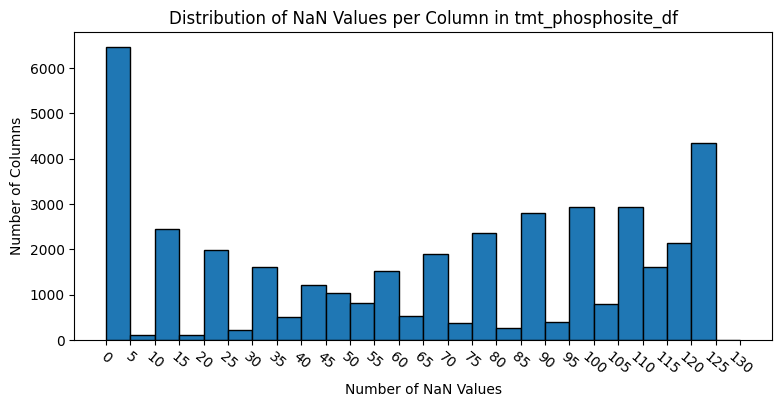

In [ ]:
# prompt: plot a histogram of the number of NaN values in each column, with bins groups of 5
tmt_phosphosite_df.replace(0, np.nan, inplace=True)
num_features = tmt_phosphosite_df.shape[1]

# Count NaN values in each column
nan_counts = tmt_phosphosite_df.isna().sum()

# Create the histogram with bins of 5
plt.figure(figsize=(9, 4))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in tmt_phosphosite_df')
plt.xticks(range(0, int(nan_counts.max()) + 5, 5), rotation=-40)
plt.show()


Original number of features: (130, 41448)
tmt phosphosite df new shape (130, 12037)
features removed: 29411


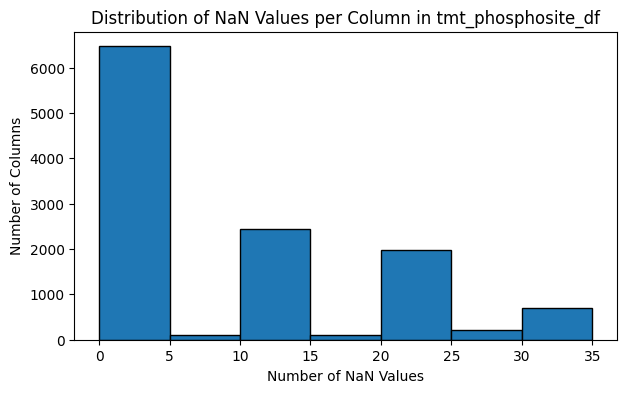

In [ ]:
# Too many sparse columns, filtering out those that have over half empty
print("Original number of features:", tmt_phosphosite_df.shape)
tmt_phosphosite_df = tmt_phosphosite_df.loc[:, tmt_phosphosite_df.isna().sum() <= (tmt_phosphosite_df.shape[0]*(1-threshold))]
print("tmt phosphosite df new shape", tmt_phosphosite_df.shape)
print("features removed:", num_features-tmt_phosphosite_df.shape[1])
# Count NaN values in each column
nan_counts = tmt_phosphosite_df.isna().sum()

# Create the histogram with bins of 5
plt.figure(figsize=(7, 4))
plt.hist(nan_counts, bins=range(0, int(nan_counts.max()) + 5, 5), edgecolor='black')
plt.xlabel('Number of NaN Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of NaN Values per Column in tmt_phosphosite_df')
plt.xticks(range(0, int(nan_counts.max()) + 5, 5))
plt.show()

In [ ]:

#print("Original number of features:", tmt_phosphosite_df.shape)
X = tmt_phosphosite_df.copy()
X = X[X.index.isin(pfs_df.index)]
train_idx = train_idx[train_idx.isin(X.index)]
test_idx = test_idx[test_idx.isin(X.index)]
print("TMT phosphosite dataset")
print("Original number of features:", str(X.shape[1]))
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

X_train_imputed_first = imputer.fit_transform(X_train)

# Calculate the variance of each column in rna_seq_df
variances = np.var(X_train_imputed, axis=0)

var_cutoffs = np.arange(1000,7001,250)
for n in var_cutoffs:
  print("testing with",n,"cutoff")
  # # Get the indices of the top 5000 columns with the highest variance
  top_indices = np.argsort(variances)[::-1][:n]
  top_cols = X_train.columns[top_indices] #column names of top 5000 variance columns

  # # Get the columns with the top 5000 highest variance
  X_train_imputed = X_train_imputed_first[:,top_indices]
  scaler.fit(X_train_imputed) #only fitted once?

  #print("X_train after selecting top 5000 variance columns", X_train_imputed.shape)

  estimator = Lasso()

  selector = RFECV(
      cv=5,
      estimator=estimator,
      scoring='r2',  # or 'r2', etc.
      n_jobs=1,
      step=10,
  )

  selector.fit(scaler.transform(X_train_imputed), y_train)
  # Get the boolean mask of selected features, length 5000
  mask = selector.support_
  selected_features = top_cols[mask]
  print("Num selected features:", str(len(selected_features)))
  print("Selected features:", selected_features.tolist())

print("Num selected features:", str(len(selected_features)))

TMT phosphosite dataset
Original number of features: 12037
testing with 1000 cutoff
Num selected features: 1
Selected features: ['AAK1:S21']
testing with 1250 cutoff
Num selected features: 1
Selected features: ['BAG4:S179']
testing with 1500 cutoff
Num selected features: 140
Selected features: ['AAK1:S21', 'AAK1:T620', 'ABCF1:S228', 'ABL2:S620', 'ACSS2:S30', 'ACTN4:S656', 'ACTN4:S159', 'ACTN4:S423', 'ACTR8:S132', 'ADAM17:S785', 'ADAM17:S791', 'ADAM17:S819', 'ADAM22:S834', 'ADAM9:S758', 'ADAM9:T761', 'ADAR:S614', 'ADAR:S825', 'ADAR:T601', 'ADAR:T603', 'ADARB1:S26', 'ADCY3:S525', 'ADCY6:S54', 'ADD1:S12', 'ADD1:S355', 'ADD1:S358', 'ADD1:S366', 'ADD1:S464', 'ADD1:S465', 'ADD1:S586', 'ADD1:T724', 'ADD2:S532', 'AEBP2:S24', 'AFDN:S1774', 'AHNAK:S1414', 'AHNAK:S3326', 'AHNAK:S5832', 'AKAP10:S187', 'APC:S2772', 'APP:S441', 'ARGLU1:S94', 'ARHGAP32:S682', 'ARHGEF11:S663', 'ARHGEF12:S1389', 'ARHGEF1:S776', 'ARHGEF5:S1126', 'ATP1A1:S16', 'ATP7A:S270', 'ATXN2:T741', 'BAG3:S274', 'BAG4:S179', 'BAIAP2

In [ ]:
phosphosite_selection = selected_features.copy()
phosphosite_selection

Index(['AHNAK:S3326', 'ANKLE2:S807', 'ATXN2:T741', 'BCL9L:S934', 'BCLAF1:S290',
       'BRD1:S128', 'CBX3:S176', 'CCDC73:T314', 'CCDC86:S47', 'CDK12:S334',
       'CDKN1C:S297', 'CDR2L:S304', 'CDR2L:S308', 'CEP170:T920',
       'CEP170B:S988', 'CEP350:S1807', 'CLASRP:S531', 'CNOT3:S291',
       'CPSF6:S513', 'CPSF7:S322', 'CTR9:S970', 'DEK:S32', 'DENND1A:S538',
       'E2F8:S417', 'EIF3B:S125', 'EML3:S889', 'FAM117B:S10', 'FBXO11:S143',
       'GLCCI1:S145', 'GTPBP1:S25', 'H1-10:S154', 'HDGFL2:S625', 'HSF1:S363',
       'HSP90AB1:S452', 'INTS6:S804', 'JPT1:S88', 'L1RE1:S27', 'LARP1:S774',
       'MGA:S924', 'MPHOSPH8:S164'],
      dtype='object')

Converged on these features

['AHNAK:S3326', 'ANKLE2:S807', 'ATXN2:T741', 'BCL9L:S934', 'BCLAF1:S290', 'BRD1:S128', 'CBX3:S176', 'CCDC73:T314', 'CCDC86:S47', 'CDK12:S334', 'CDKN1C:S297', 'CDR2L:S304', 'CDR2L:S308', 'CEP170:T920', 'CEP170B:S988', 'CEP350:S1807', 'CLASRP:S531', 'CNOT3:S291', 'CPSF6:S513', 'CPSF7:S322', 'CTR9:S970', 'DEK:S32', 'DENND1A:S538', 'E2F8:S417', 'EIF3B:S125', 'EML3:S889', 'FAM117B:S10', 'FBXO11:S143', 'GLCCI1:S145', 'GTPBP1:S25', 'H1-10:S154', 'HDGFL2:S625', 'HSF1:S363', 'HSP90AB1:S452', 'INTS6:S804', 'JPT1:S88', 'L1RE1:S27', 'LARP1:S774', 'MGA:S924', 'MPHOSPH8:S164']


In [ ]:
phosphosite_selected = tmt_phosphosite_df.copy()[phosphosite_selection]

imputer = KNNImputer(n_neighbors=3)
scaler = StandardScaler()

imputer.fit(phosphosite_selected.loc[train_idx])
phosphosite_selected_train = imputer.transform(phosphosite_selected.loc[train_idx])
phosphosite_selected_test = imputer.transform(phosphosite_selected.loc[test_idx])

scaler.fit(phosphosite_selected_train)
phosphosite_selected_train = pd.DataFrame(scaler.transform(phosphosite_selected_train), columns=phosphosite_selected.columns, index=train_idx)
phosphosite_selected_train = phosphosite_selected_train.add_prefix("TMT_PHOSPHO_")

phosphosite_selected_test = pd.DataFrame(scaler.transform(phosphosite_selected_test), columns=phosphosite_selected.columns, index=test_idx)
phosphosite_selected_test = phosphosite_selected_test.add_prefix("TMT_PHOSPHO_")

This was the set that RFECV started to converge on after multiple variance cutoff thresholds


['ABL2:S620', 'AAK1:T620', 'CEP350:S1818', 'BASP1:T31', 'CCDC86:S47',
       'ATXN2:T741', 'CLASP1:S559', 'ACSS2:S30', 'CCSAP:S145', 'BCL9L:S934',
       'CEP350:S1807', 'BAIAP2:T340', 'ARHGAP32:S682', 'AHNAK:S1414',
       'CEP170B:S988', 'CDR2L:S308', 'CDK11A:S47', 'BCLAF1:S290', 'CHTF18:S64',
       'CEP170:T920', 'BRD1:S128', 'ARHGEF12:S1389', 'ARGLU1:S94',
       'CCDC73:T314', 'CDR2L:S304', 'AAK1:S21', 'C9orf78:S24', 'CEP89:S44',
       'CDK12:S334', 'BRCA1:S1286']

## Random Forest results (with RFECV feature selection)

About 2x as many features being considered this time compared to Lasso feature selection.

### Training model with clinical data

In [ ]:
combined_df_train = pd.concat([clinical_df_encoded, cbc_selected_train, rna_selected_train, tmt_prot_selected_train, phosphosite_selected_train], axis=1, join="inner")
combined_df_test = pd.concat([clinical_df_encoded, cbc_selected_test, rna_selected_test, tmt_prot_selected_test, phosphosite_selected_test], axis=1, join="inner")

print("Combined train shape:", combined_df_train.shape)
print("Combined test shape:", combined_df_test.shape)

pfs_final_train = pfs_df.loc[combined_df_train.index]["Progression-free time (months)"]
pfs_final_test = pfs_df.loc[combined_df_test.index]["Progression-free time (months)"]

print("pfs final train shape:", pfs_final_train.shape)
print("pfs final test shape:", pfs_final_test.shape)



Combined train shape: (104, 209)
Combined test shape: (26, 209)
pfs final train shape: (104,)
pfs final test shape: (26,)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

results = {"RMSE":[],
           "R2":[],
           "c-index":[]}
important_features = set()
importance_counts = {}
importance_sum = {}
train_count=0
start = 100
end = 301
for n in np.arange(start, end, 10):
  print("testing with",n,"trees")
  train_count += 1
  model = RandomForestRegressor(
      n_estimators=n,        # number of trees (after testing in intervals of 10, this seemed to be the best)
      max_depth=None,          # can tune this
      random_state=42,
      n_jobs=-1                # use all processors
  )
  model.fit(combined_df_train, pfs_final_train)

  y_pred = model.predict(combined_df_test)

  rmse = mean_squared_error(np.asarray(pfs_final_test), y_pred)
  r2 = r2_score(np.asarray(pfs_final_test), y_pred)
  c_index = concordance_index(np.asarray(pfs_final_test), -y_pred)

  results["RMSE"].append(rmse)
  results["R2"].append(r2)
  results["c-index"].append(c_index)

  importances = model.feature_importances_
  feature_importances = pd.Series(importances, index=combined_df_test.columns)
  feature_importances = feature_importances.sort_values(ascending=False)
  top_20_features = feature_importances[:20]
  if n == start:
    important_features = set(top_20_features.index)
  else:
    important_features = important_features.intersection(set(top_20_features.index))

  for feature in top_20_features.index:
        importance_counts[feature] = importance_counts.get(feature, 0) + 1
        importance_sum[feature] = importance_sum.get(feature, 0) + top_20_features[feature]

importance_df_2 = pd.DataFrame({'counts': importance_counts, 'sum': importance_sum}).sort_values(by='sum', ascending=False)
importance_df_2["avg relative importance"] = importance_df_2["sum"]/train_count
print()
metrics_df_2 = pd.DataFrame(results, index=np.arange(start,end,10))
metrics_df_2.index.name = "n_estimators"
metrics_df_2 = metrics_df_2.T
metrics_df_2.style.background_gradient(axis=1).format(precision=2)

testing with 100 trees
testing with 110 trees
testing with 120 trees
testing with 130 trees
testing with 140 trees
testing with 150 trees
testing with 160 trees
testing with 170 trees
testing with 180 trees
testing with 190 trees
testing with 200 trees
testing with 210 trees
testing with 220 trees
testing with 230 trees
testing with 240 trees
testing with 250 trees
testing with 260 trees
testing with 270 trees
testing with 280 trees
testing with 290 trees
testing with 300 trees



n_estimators,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300
RMSE,74.45,74.73,75.45,76.92,78.19,78.26,79.12,79.08,79.25,79.28,78.04,78.26,77.77,77.48,77.43,77.23,76.59,77.35,77.74,77.56,77.86
R2,0.11,0.11,0.10,0.08,0.07,0.07,0.06,0.06,0.06,0.06,0.07,0.07,0.07,0.08,0.08,0.08,0.09,0.08,0.07,0.08,0.07
c-index,0.31,0.30,0.32,0.33,0.36,0.34,0.36,0.36,0.36,0.36,0.36,0.35,0.35,0.34,0.35,0.34,0.33,0.34,0.34,0.35,0.35


In [ ]:
importance_df_2

,counts,sum,avg relative importance
TMT_PHOSPHO_MGA:S924,21,1.467312,0.069872
TMT_PHOSPHO_CCDC73:T314,21,1.038112,0.049434
TMT_PHOSPHO_DEK:S32,21,0.782816,0.037277
TMT_PHOSPHO_HDGFL2:S625,21,0.708375,0.033732
TMT_PHOSPHO_INTS6:S804,21,0.676761,0.032227
TMT_PHOSPHO_CNOT3:S291,21,0.644207,0.030677
TMT_PHOSPHO_H1-10:S154,21,0.566754,0.026988
TMT_PHOSPHO_ATXN2:T741,21,0.539696,0.025700
TMT_PROT_KLC2,21,0.487326,0.023206
TMT_PHOSPHO_EIF3B:S125,21,0.463918,0.022091


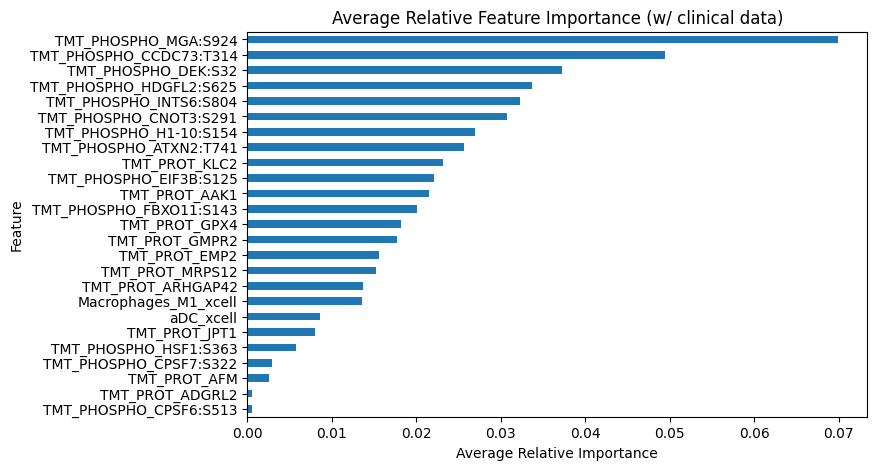

In [ ]:
importance_df_2["avg relative importance"][::-1].plot(kind='barh', figsize=(8, 5))
plt.xlabel("Average Relative Importance")
plt.ylabel("Feature")
plt.title("Average Relative Feature Importance (w/ clinical data)")
plt.show()

### Training model w/o clinical data

In [ ]:
combined_df_train = pd.concat([rna_selected_train, tmt_prot_selected_train,
                        phosphosite_selected_train], axis=1, join='inner') #TOOK OUT CLINICAL DATA

pfs_final_train = pfs_df[pfs_df.index.isin(combined_df_train.index)]["Progression-free time (months)"]

combined_df_test = pd.concat([rna_selected_test, tmt_prot_selected_test,
                        phosphosite_selected_test], axis=1, join='inner')

pfs_final_test = pfs_df[pfs_df.index.isin(combined_df_test.index)]["Progression-free time (months)"]

print()

print("combined df train", combined_df_train.shape)
print("pfs train", pfs_final_train.shape)

print("combined df test", combined_df_test.shape)
print("pfs test", pfs_final_test.shape)

results = {"RMSE":[],
           "R2":[],
           "c-index":[]}

important_features = set()
importance_counts = {}
importance_sum = {}
train_count=0
start = 100
end = 301
for n in np.arange(start,end,10):
  print(f"n_estimators: {n}")
  train_count += 1
  model = RandomForestRegressor(
      n_estimators=n,        # number of trees (after testing in intervals of 10, 210 seemed to be the best)
      max_depth=None,          # can tune this
      random_state=42,
      n_jobs=-1                # use all processors
  )
  model.fit(combined_df_train, pfs_final_train)

  y_pred = model.predict(combined_df_test)

  rmse = mean_squared_error(np.asarray(pfs_final_test), y_pred)
  r2 = r2_score(np.asarray(pfs_final_test), y_pred)
  c_index = concordance_index(np.asarray(pfs_final_test), -y_pred)

  results["RMSE"].append(rmse)
  results["R2"].append(r2)
  results["c-index"].append(c_index)

  importances = model.feature_importances_
  feature_importances = pd.Series(importances, index=combined_df_test.columns)
  feature_importances = feature_importances.sort_values(ascending=False)

  top_20_features = feature_importances[:20]
  if n == 100:
    important_features = set(top_20_features.index)
  else:
    important_features = important_features.intersection(set(top_20_features.index))

  for feature in top_20_features.index:
        importance_counts[feature] = importance_counts.get(feature, 0) + 1
        importance_sum[feature] = importance_sum.get(feature, 0) + top_20_features[feature]

importance_df_no_clin_2 = pd.DataFrame({'counts': importance_counts, 'sum': importance_sum}).sort_values(by='sum', ascending=False)
importance_df_no_clin_2["avg relative importance"] = importance_df_no_clin_2["sum"]/train_count

metrics_df_no_clin_2 = pd.DataFrame(results, index=np.arange(start,end,10)).T
metrics_df_no_clin_2.index.name = "n_estimators"
metrics_df_no_clin_2.style.background_gradient(axis=1).format(precision=2)


combined df train (104, 137)
pfs train (104,)
combined df test (26, 137)
pfs test (26,)
n_estimators: 100
n_estimators: 110
n_estimators: 120
n_estimators: 130
n_estimators: 140
n_estimators: 150
n_estimators: 160
n_estimators: 170
n_estimators: 180
n_estimators: 190
n_estimators: 200
n_estimators: 210
n_estimators: 220
n_estimators: 230
n_estimators: 240
n_estimators: 250
n_estimators: 260
n_estimators: 270
n_estimators: 280
n_estimators: 290
n_estimators: 300


,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300
n_estimators,,,,,,,,,,,,,,,,,,,,,
RMSE,95.07,92.66,91.17,90.70,91.89,93.18,92.14,91.97,92.34,91.80,91.56,92.82,93.84,94.27,94.34,94.29,95.22,95.08,95.48,96.11,96.29
R2,-0.13,-0.10,-0.09,-0.08,-0.09,-0.11,-0.10,-0.10,-0.10,-0.09,-0.09,-0.11,-0.12,-0.12,-0.12,-0.12,-0.13,-0.13,-0.14,-0.15,-0.15
c-index,0.54,0.54,0.53,0.52,0.54,0.55,0.54,0.54,0.54,0.53,0.53,0.54,0.55,0.55,0.55,0.55,0.56,0.56,0.56,0.56,0.57


In [ ]:
importance_df_no_clin_2

,counts,sum,avg relative importance
TMT_PHOSPHO_JPT1:S88,21,1.556081,0.074099
TMT_PHOSPHO_HSF1:S363,21,1.031762,0.049132
RNA_TTLL10,21,0.868908,0.041377
TMT_PROT_JPT1,21,0.585109,0.027862
RNA_AL645728.1,21,0.517609,0.024648
RNA_PERM1,21,0.482215,0.022963
TMT_PHOSPHO_CBX3:S176,21,0.447581,0.021313
TMT_PROT_ADGRL2,21,0.430751,0.020512
TMT_PROT_DDX52,21,0.379573,0.018075
RNA_LINC01786,21,0.365200,0.017390


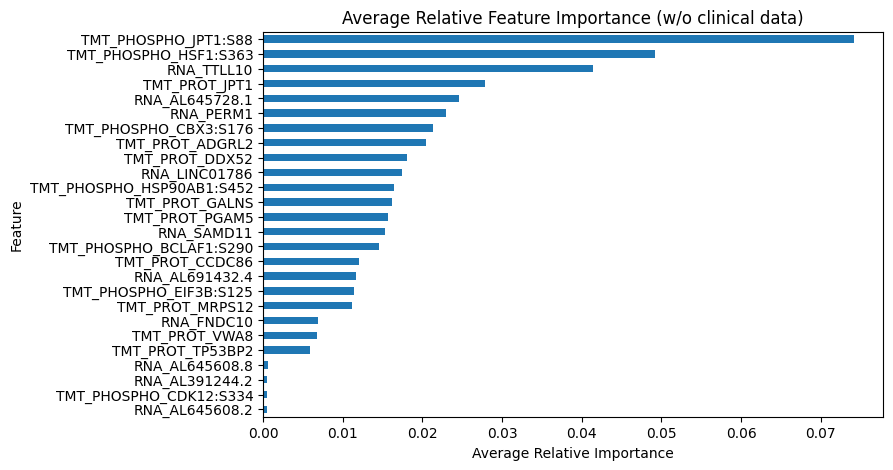

In [ ]:
plt.figure(figsize=(8, 5))
importance_df_no_clin_2["avg relative importance"][::-1].plot(kind='barh')
plt.xlabel("Average Relative Importance")
plt.ylabel("Feature")
plt.title("Average Relative Feature Importance (w/o clinical data)")
plt.show()
#

In [ ]:
combined_results = pd.concat([metrics_df_2, metrics_df_no_clin_2], keys=["w/ clinical data", "w/o clinical data"])
combined_results.style.background_gradient(axis=1).format(precision=2)